In [23]:
from IPython.display import display, Markdown

In [24]:
display(Markdown("# Analysis of recent coronavirus data for different countries and regions"))

display(Markdown("### Table of contents"))


display(Markdown("[General Statistics](#General-statistics)"))
display(Markdown("[List of most affected countries](#List-of-most-affected-countries)"))
display(Markdown("[Global situation](#Global-situation)"))
display(Markdown("[Evolution of cases](#Evolution-of-cases)"))
display(Markdown("[Europe](#Europe)"))
display(Markdown("[United States](#United-States)"))
display(Markdown("[Comparison of different countries](#Comparison-of-different-countries)"))
display(Markdown("[Early onset: China regions](#Early-onset:-China-regions)"))
display(Markdown("[Other countries in Asia](#Other-countries-in-Asia)"))

# Analysis of recent coronavirus data for different countries and regions

### Table of contents

[General Statistics](#General-statistics)

[List of most affected countries](#List-of-most-affected-countries)

[Global situation](#Global-situation)

[Evolution of cases](#Evolution-of-cases)

[Europe](#Europe)

[United States](#United-States)

[Comparison of different countries](#Comparison-of-different-countries)

[Early onset: China regions](#Early-onset:-China-regions)

[Other countries in Asia](#Other-countries-in-Asia)

In [25]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import curve_fit
import datetime
import matplotlib.dates as mdates
from IPython.display import display, Markdown
from matplotlib.ticker import ScalarFormatter
#from scipy.interpolate import interp1d
from scipy.signal import savgol_filter


In [26]:
today = datetime.datetime.today().strftime('%A %d %B %Y')
display(Markdown(f"## Important note"))
display(Markdown(f"From June 10, this report will not be updated regularly, but occasionally. By the end of June, the report will be mostly fixed and only updated sporadically."))
display(Markdown(f"#### Last updated on {today}"))
display(Markdown("Author: Javier Moldon"))
display(Markdown("More info in [https://github.com/jmoldon/coronavirus_analysis](https://github.com/jmoldon/coronavirus_analysis)"))
display(Markdown("link to this report: [https://jmoldon.github.io/coronavirus_analysis/cvid_report.html](https://jmoldon.github.io/coronavirus_analysis/cvid_report.html)"))


## Important note

From June 10, this report will not be updated regularly, but occasionally. By the end of June, the report will be mostly fixed and only updated sporadically.

#### Last updated on Thursday 16 July 2020

Author: Javier Moldon

More info in [https://github.com/jmoldon/coronavirus_analysis](https://github.com/jmoldon/coronavirus_analysis)

link to this report: [https://jmoldon.github.io/coronavirus_analysis/cvid_report.html](https://jmoldon.github.io/coronavirus_analysis/cvid_report.html)

> "No matter how much you talk about them or think about them, you will still underestimate exponentials".  
Jeremy Howard

In [27]:
matplotlib.rcParams["figure.figsize"] = 12,8
import warnings
do_debug = False
if not do_debug:
    warnings.filterwarnings('ignore')
    #warnings.filterwarnings('default')

In [28]:
display(Markdown("# General statistics"))

#display(Markdown("Data comes from Johns Hopkins University at https://github.com/CSSEGISandData/COVID-19 that is updated daily."))

# General statistics

In [29]:
# download data from github
if True:
    #url = 'https://raw.githubusercontent.com/ulklc/covid19-timeseries/master/countryReport/raw/rawReport.csv'
    url = 'https://raw.githubusercontent.com/datasets/covid-19/master/data/time-series-19-covid-combined.csv'
    filename = os.path.basename(url)
    command1 = f'curl -o {filename} {url}'
    os.system(command1)
    os.system(f'mv {filename} ./data/')
    # Get data for Comunidades autonomas Spain
    os.system('wget https://raw.githubusercontent.com/datadista/datasets/master/COVID%2019/ccaa_covid19_fallecidos_long.csv; mv ccaa_covid19_fallecidos_long.csv ./data/')

In [30]:
data_path = './data/'
#file1 = data_path + 'rawReport.csv'
file1 = data_path + 'time-series-19-covid-combined.csv'
data = pd.read_csv(file1, error_bad_lines=False)
#display(df1.head())
ccaa = pd.read_csv('./data/ccaa_covid19_fallecidos_long.csv')
ccaa['DateTime'] = pd.to_datetime(ccaa['fecha'])

In [31]:
#ulklc/covid19-timeseries
#data = data.rename(columns={'confirmed': 'Confirmed', 'recovered': 'Recovered', 'death':'Deaths', 'countryName':'Country/Region'})
#data['Active'] = data['Confirmed']-data['Deaths']-data['Recovered']
#data['DateTime'] = pd.to_datetime(data['day'])
#data['Province/State'] = ''

data = data.groupby(['Date','Country/Region']).sum().reset_index()

cols = ['Confirmed', 'Recovered', 'Deaths']
data = data.dropna(subset=cols)
for col in cols:
    data[col] = data[col].astype(int)
data['Active'] = data['Confirmed']-data['Deaths']-data['Recovered']
data['DateTime'] = pd.to_datetime(data['Date'])

for column in ['Confirmed', 'Deaths', 'Recovered', 'Active']:
    data[column+'_diff'] = data.groupby(['Country/Region'])[column].apply(lambda x:x.diff())


In [32]:
#Example table:
#data[['Country/Region','Confirmed','Deaths','Recovered']]

In [33]:
#I need to remove a few points manually that I identified as bad ones
#data.drop(data[(data['Country/Region']=='Spain') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
#data.drop(data[(data['Country/Region']=='Italy') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
#data.drop(data[(data['Country/Region']=='Netherlands') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
#data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-12', '%Y-%m-%d'))].index, inplace=True)
#data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-13', '%Y-%m-%d'))].index, inplace=True)
#data.drop(data[(data['Country/Region']=='United Kingdom') & (data['Province/State']=='United Kingdom') & (data['DateTime'] == datetime.datetime.strptime('2020-03-15', '%Y-%m-%d'))].index, inplace=True)

## List of most affected countries

Sorted by highest number of deaths

In [34]:
most_cases_c = data.loc[data.groupby(['Country/Region'])['DateTime'].idxmax()].sort_values(by='Deaths')[::-1][0:25]
columns = ['Deaths', 'Confirmed', 'Recovered', 'Active']
for column in columns:
    most_cases_c[column] = most_cases_c.apply(lambda row: f"{row[column]} ({row[column+'_diff']:+.0f})", axis=1)
display(most_cases_c[['Country/Region']+columns].set_index('Country/Region'))

Deaths         Confirmed         Recovered  \
Country/Region                                                      
US              137407 (+941)  3497847 (+66273)  1075882 (+26784)   
Brazil          75366 (+1233)  1966748 (+39924)  1350098 (+26673)   
United Kingdom    45138 (+85)     293469 (+538)         1386 (+1)   
Mexico           36906 (+579)    317635 (+6149)    252368 (+6538)   
Italy             34997 (+13)     243506 (+162)     196016 (+575)   
France            30123 (+91)     210568 (+928)      78945 (+223)   
Spain              28413 (+4)     257494 (+875)       150376 (+0)   
India            24914 (+605)   968857 (+32676)   612768 (+20736)   
Iran             13410 (+199)    264561 (+2388)    227561 (+2291)   
Peru             12417 (+188)    337751 (+3884)    226400 (+3139)   
Russia           11753 (+156)    745197 (+6410)   522375 (+10417)   
Belgium             9788 (+1)       62872 (+91)       17242 (+19)   
Germany             9080 (+2)     200890 (+434)     186000 (+900)   
Canada             8857 (+12)     110693 (+343)      74067 (+354)   
Chile             7186 (+117)    321205 (+1712)    292085 (+2865)   
Netherlands         6155 (+1)      51471 (+109)          193 (+0)   
Colombia          5969 (+182)    159898 (+5621)     68806 (+2997)   
Sweden             5572 (+27)      76492 (+491)            0 (+0)   
Pakistan           5426 (+40)    257914 (+2145)    178737 (+5927)   
Turkey             5419 (+17)     215940 (+947)    197733 (+1013)   
Ecuador            5158 (+28)      70329 (+759)      30641 (+157)   
China               4644 (+2)       85246 (+20)       80005 (+38)   
South Africa      4453 (+107)   311049 (+12757)   160693 (+14414)   
Egypt              4067 (+59)      84843 (+913)      26135 (+591)   
Indonesia          3797 (+87)     80094 (+1522)     39050 (+1414)   

                          Active  
Country/Region                    
US              2284558 (+38548)  
Brazil           541284 (+12018)  
United Kingdom     246945 (+452)  
Mexico              28361 (-968)  
Italy               12493 (-426)  
France             101500 (+614)  
Spain               78705 (+871)  
India            331175 (+11335)  
Iran                23590 (-102)  
Peru                98934 (+557)  
Russia            211069 (-4163)  
Belgium              35842 (+71)  
Germany              5810 (-468)  
Canada               27769 (-23)  
Chile              21934 (-1270)  
Netherlands         45123 (+108)  
Colombia           85123 (+2442)  
Sweden              70920 (+464)  
Pakistan           73751 (-3822)  
Turkey               12788 (-83)  
Ecuador             34530 (+574)  
China                  597 (-20)  
South Africa      145903 (-1764)  
Egypt               54641 (+263)  
Indonesia            37247 (+21)

In [35]:
def select_country(data, country='', province='', start_date='2020-01-01', end_date='2021-12-31'):
    # Select by country
    if country != '':
        cond1 = data['Country/Region'] == country
    else:
        cond1 = data['Country/Region'].notna()  # Select any country
    ## Select by province
    #if province != '':
    #    cond2 = data['Province/State'] == province
    #else:
    #    cond2 = data['Province/State'] != np.nan  # Select any province
    # Select by time range
    if start_date != '':
        t0 = datetime.datetime.strptime(start_date, '%Y-%m-%d')
    else:
        t0 = datetime.datetime.strptime('2000-01-01', '%Y-%m-%d')
    if end_date != '':
        t1 = datetime.datetime.strptime(end_date, '%Y-%m-%d')
    else:
        t1 = datetime.datetime.strptime('9999-01-01', '%Y-%m-%d')
    cond3 = (data['DateTime'] >= t0) & (data['DateTime'] < t1)
    #selection = cond1&cond2&cond3
    selection = cond1&cond3

    if do_debug:
        print('Number of entries per country: {}'.format(cond1.sum()))
        #print('Number of entries per province: {}'.format(cond2.sum()))
        print('Number of entries per time range: {}'.format(cond3.sum()))
        print('Number of entries selected: {}'.format(selection.sum()))
    return data[selection]

# Global situation

These plots show the global situation of the countries with higher number of deaths.

### Deaths

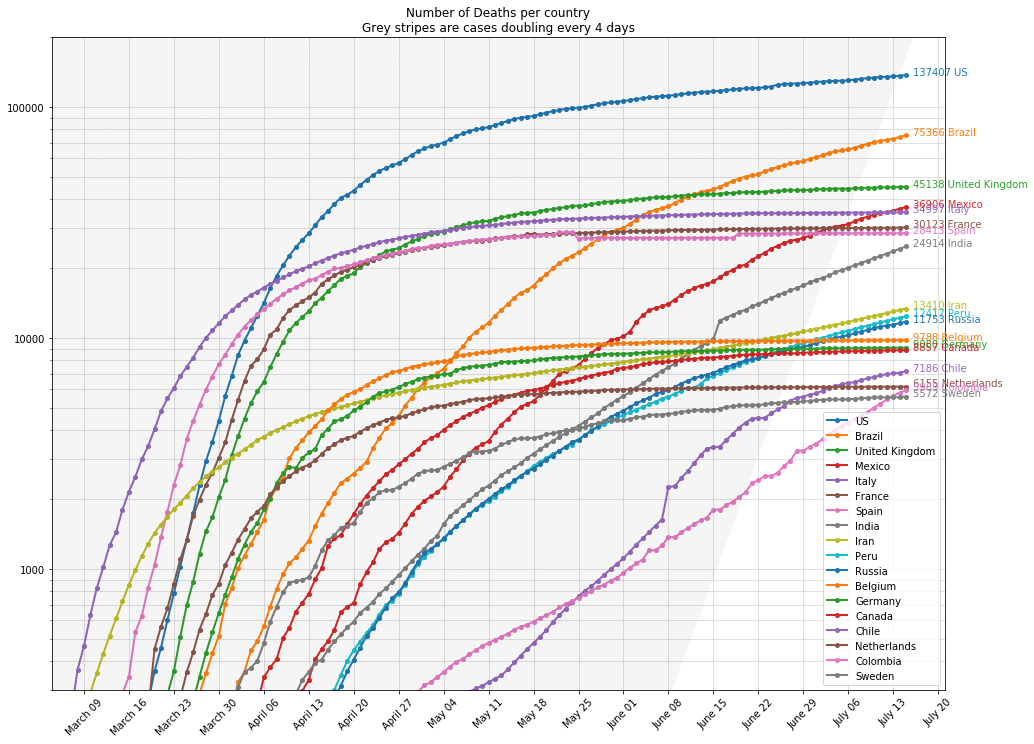

In [72]:
display(Markdown('### Deaths'))

fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((1,1), (0, 0))

countries_sorted = data.loc[data.groupby(['Country/Region'])['DateTime'].idxmax()].sort_values(by='Deaths')[::-1]['Country/Region']
for c in countries_sorted[0:18]: 
    my_country = data[data['Country/Region']==c]
    l = ax1.plot(my_country['DateTime'], my_country['Deaths'], 'o-', ms=4, label=c, lw=2)
    ax1.annotate(f"{my_country['Deaths'].iloc[-1]} {c}",
                     (my_country['DateTime'].iloc[-1]+datetime.timedelta(days=1),my_country['Deaths'].iloc[-1]), color=l[0].get_color())

t = my_country['DateTime']
n = 4 # days to double
for j in np.arange(-7,10):
    ax1.plot(t+datetime.timedelta(days=6), np.array([10.**j*2**(i/n) for i, ti in enumerate(t)]), '-k', alpha=0.04, lw=80)
    
ax1.legend(loc='top left')
ax1.set_yscale('log')
ax1.set_ylim(300, 200000)
ax1.set_xlim(my_country['DateTime'].iloc[0]+datetime.timedelta(days=42), my_country['DateTime'].iloc[-1]+datetime.timedelta(days=6))
ax1.set_title(f'Number of Deaths per country\nGrey stripes are cases doubling every {n} days');

hfmt = matplotlib.dates.DateFormatter('%B %d')
ax1.xaxis.set_major_formatter(hfmt)
loc  = matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO, interval=1)
loc2 = matplotlib.dates.DayLocator(interval=1)
ax1.xaxis.set_major_locator(loc)
#ax1.xaxis.set_minor_locator(loc2)

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)
    
ax1.xaxis.set_tick_params(rotation=45)
ax1.grid(which='both', alpha=0.5)

fig.savefig(f'./plots/most_deaths_evolution.png', bbox_inches='tight', dpi=100)

### Confirmed Cases

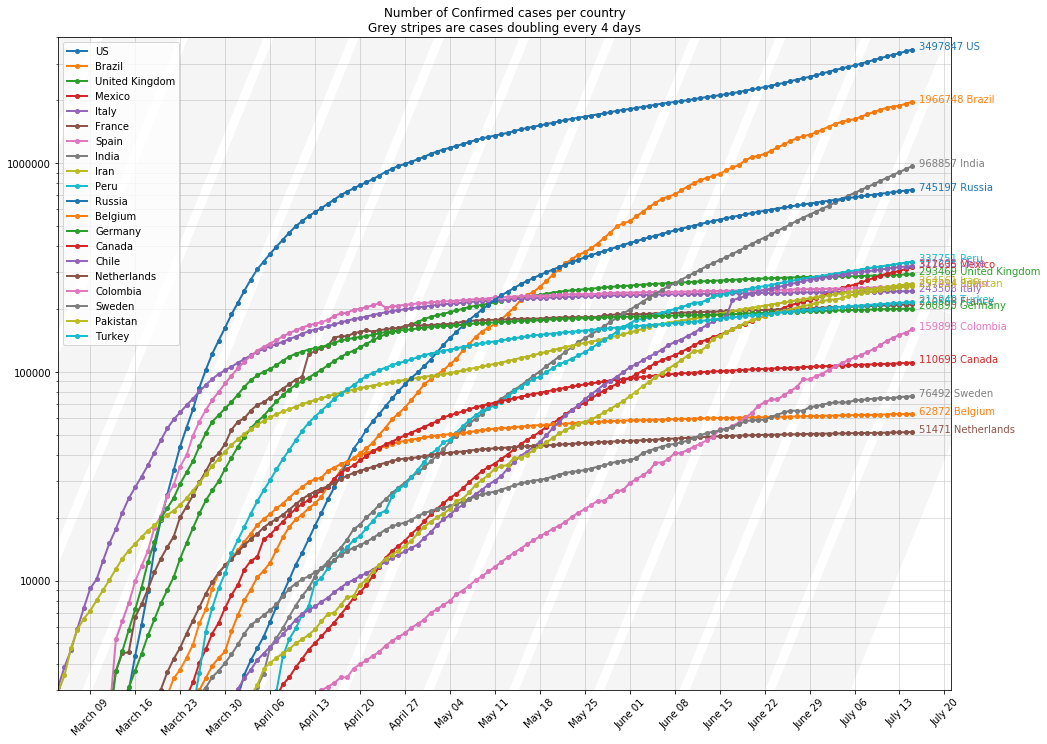

In [69]:
display(Markdown('### Confirmed Cases'))

fig = plt.figure(figsize=(16, 12))
ax1 = plt.subplot2grid((1,1), (0, 0))

countries_sorted = data.loc[data.groupby(['Country/Region'])['DateTime'].idxmax()].sort_values(by='Deaths')[::-1]['Country/Region']
for c in countries_sorted[0:20]: 
    my_country = data[data['Country/Region']==c]
    l = ax1.plot(my_country['DateTime'], my_country['Confirmed'], 'o-', ms=4, label=c, lw=2)
    ax1.annotate(f"{my_country['Confirmed'].iloc[-1]} {c}",
                     (my_country['DateTime'].iloc[-1]+datetime.timedelta(days=1),my_country['Confirmed'].iloc[-1]), color=l[0].get_color())

t = my_country['DateTime'][1:]
n = 4 # days to double
for j in np.arange(-8,10):
    ax1.plot(t+datetime.timedelta(days=6), np.array([10.**j*2**(i/n) for i, ti in enumerate(t)]), '-k', alpha=0.04, lw=70)

ax1.legend(loc='top left')
ax1.set_yscale('log')
ax1.set_ylim(3000, 4000000)
ax1.set_xlim(my_country['DateTime'].iloc[0]+datetime.timedelta(days=42), my_country['DateTime'].iloc[-1]+datetime.timedelta(days=6))
ax1.set_title(f'Number of Confirmed cases per country\nGrey stripes are cases doubling every {n} days');
hfmt = matplotlib.dates.DateFormatter('%B %d')

ax1.xaxis.set_major_formatter(hfmt)
loc  = matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO, interval=1)
loc2 = matplotlib.dates.DayLocator(interval=1)
ax1.xaxis.set_major_locator(loc)
#ax1.xaxis.set_minor_locator(loc2)

formatter = ScalarFormatter()
formatter.set_scientific(False)
ax1.yaxis.set_major_formatter(formatter)
    
ax1.xaxis.set_tick_params(rotation=45)
ax1.grid(which='both', alpha=0.5)

fig.savefig(f'./plots/most_cases_evolution.png', bbox_inches='tight', dpi=100)

In [38]:
def plot_country(data_country, prediction, ylim=2e6, death_lim=300, n=4):
    gridsize = (4, 2)
    fig = plt.figure(figsize=(18, 12))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=2)
    ax2 = plt.subplot2grid(gridsize, (0, 1), rowspan=2)
    ax3 = plt.subplot2grid(gridsize, (2, 0), colspan=1, rowspan=2)
    ax4 = plt.subplot2grid(gridsize, (2, 1), colspan=1, rowspan=2)
    plt.subplots_adjust(hspace=0.7)

    axs = [ax1,ax2,ax3, ax4]

    colors = {'Confirmed': '#3498db',
              'Deaths': 'tomato',
              'Recovered': 'g',
               'Active': 'k'}
    for ax in [ax1,ax2]:
        ax.plot(data_country['DateTime'], data_country['Confirmed'], 'o', color=colors['Confirmed'], label='Confirmed')
        ax.plot(data_country['DateTime'], data_country['Deaths'],    'o', color=colors['Deaths'], label='Deaths')
        ax.plot(data_country['DateTime'], data_country['Recovered'], 'o', color=colors['Recovered'], label='Recovered')
        ax.plot(data_country['DateTime'], data_country['Active'],    'o', color=colors['Active'], label='Active', zorder=-10)   
        ax.plot(data_country['DateTime'], data_country['Recovered_fit'], '-', color=colors['Recovered'], label='')
        ax.plot(data_country['DateTime'], data_country['Confirmed_fit'], '-', color=colors['Confirmed'], label='')
        ax.plot(data_country['DateTime'], data_country['Deaths_fit'],    '-', color=colors['Deaths'], label='')
        # Model and prediction
        for column in ['Confirmed', 'Deaths', 'Recovered']:
            ax.plot(prediction['DateTime'], prediction[column+'_pred'], '--', color=colors[column], label='')
            ax.fill_between(prediction['DateTime'], prediction[column+'_pred_upper'], prediction[column+'_pred_lower'], color=colors[column], alpha=0.5)
        if n!=0:
            #Doubling rate every n days
            t = prediction['DateTime']
            ax1.set_title(f'Grey stripes are cases doubling every {n} days')
            for j in np.arange(-10,15, 1):
                ax1.plot(t, np.array([10.**j*2**(i/n) for i, ti in enumerate(t)]), '-k', alpha=0.03, lw=25)
    # Active
    active_fit = data_country['Confirmed_fit']-data_country['Recovered_fit']-data_country['Deaths_fit']
    active_pred = prediction['Confirmed_pred']-prediction['Recovered_pred']-prediction['Deaths_pred']    
    for ax in [ax1,ax2]:
        ax.plot(data_country['DateTime'], active_fit,'-', color=colors['Active'], label='', zorder=-10)
        ax.plot(prediction['DateTime'], active_pred, '--', color=colors['Active'], label='', zorder=-10)

    # Death increase
    death_diff = data_country[['DateTime', 'Deaths', 'Deaths_diff']]
    #death_diff.drop(death_diff[death_diff['Deaths_diff']==0].index, inplace=True)
    death_diff['timespan'] = death_diff['DateTime'].diff()/ np.timedelta64(1, 'D')
    death_diff['deaths_per_day'] =  death_diff['Deaths_diff']/death_diff['timespan'] 
    dd = death_diff['deaths_per_day'].values
    dd[np.isnan(dd)]=0
    for ax in [ax3,ax4]:
        ax.plot(death_diff['DateTime'], death_diff['deaths_per_day'], drawstyle='steps', color='tomato', lw=3, label='Deaths per day')
        ax.fill_between(death_diff['DateTime'], death_diff['deaths_per_day'], step="pre", color='tomato', alpha=0.4)
        # Prediction
        ax.plot(data_country['DateTime'], data_country['Deaths_fit'].diff(), '-', color='k', lw=2, label='Predicted')
        ax.plot(prediction['DateTime'], prediction['Deaths_pred'].diff(), '--', color='k', lw=2, label='')
        ax.plot(prediction['DateTime'], prediction['Deaths_pred_upper'].diff(), ':', color='k', lw=1, label='')
        ax.plot(prediction['DateTime'], prediction['Deaths_pred_lower'].diff(), ':', color='k', lw=1, label='')
        #ax.plot(death_diff['DateTime'], savgol_filter(dd, 3, 1), 'k-', label='Smooth')  
    
    ax1.set_ylim(20,ylim)
    ax2.set_ylim(-0.1*np.max(prediction['Deaths_pred']),)
    #ax3.set_ylim(0.3, np.nanmax([10, int(np.max(1.5*data_country['Deaths_diff']))]))
    #ax4.set_ylim(0, np.nanmax([10, int(np.max(1.5*data_country['Deaths_diff']))]))
    ax3.set_ylim(5, death_lim)
    ax4.set_ylim(0, death_lim)
    
    ax1.set_ylabel('Number of cases (log scale)')
    ax2.set_ylabel('Number of cases (linear scale)')
    ax3.set_ylabel('Deaths per day (log scale)')
    ax4.set_ylabel('Deaths per day (linear scale)')
    
    for axi in axs:
        axi.xaxis.set_tick_params(rotation=45)
        axi.grid(which='both', alpha=0.3)
        axi.legend()
        axi.set_xlim(data_country['DateTime'].iloc[0], prediction['DateTime'].iloc[-1])
        hfmt = matplotlib.dates.DateFormatter('%B %d')
        axi.xaxis.set_major_formatter(hfmt)
        loc  = matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO, interval=1)
        loc2 = matplotlib.dates.DayLocator(interval=1)
        axi.xaxis.set_major_locator(loc)
        #ax.xaxis.set_minor_locator(loc2)
    
    country = data_country['Country/Region'].unique()[0]
    #province = data_country['Province/State'].unique()[0]
    start_date = data_country['DateTime'].iloc[0]
    end_date = data_country['DateTime'].iloc[-1]
    #fig.suptitle(f"{country} {province}\nDate range: {start_date.strftime('%d %m %Y')} to {end_date.strftime('%d %m %Y')}", fontsize=16)
    fig.suptitle(f"{country}\nDate range: {start_date.strftime('%d %m %Y')} to {end_date.strftime('%d %m %Y')}", fontsize=16)
    #ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax3.set_yscale('log')
    formatter = ScalarFormatter()
    formatter.set_scientific(False)
    ax1.yaxis.set_major_formatter(formatter)
    ax3.yaxis.set_major_formatter(formatter)
    province=''
    fig.savefig(f'./plots/{country}{province}.png', bbox_inches='tight', dpi=100)
    return fig, axs

In [39]:
hfmt = matplotlib.dates.DateFormatter('%B %d')
loc = matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO, interval=1)

def plot_country_deaths(data, death_lim=2000):
    fig = plt.figure(figsize=(16,12))
    countries_sorted = data.loc[data.groupby(['Country/Region'])['DateTime'].idxmax()].sort_values(by='Deaths')[::-1]['Country/Region']
    t0 = datetime.datetime.strptime('2020-03-01', '%Y-%m-%d')
    t1 = (data[data['Country/Region']==countries_sorted.iloc[0]])['DateTime'].iloc[-1]
    for i, c in enumerate(countries_sorted[0:12]):
        ax = fig.add_subplot(3, 4, i+1)
        my_country = data[data['Country/Region']==c]
        my_country = my_country[my_country['DateTime']> t0]
        # Death increase
        death_diff = my_country[['DateTime', 'Deaths', 'Deaths_diff']]
        death_diff.drop(death_diff[death_diff['Deaths_diff']==0].index, inplace=True)
        death_diff['timespan'] = death_diff['DateTime'].diff()/ np.timedelta64(1, 'D')
        death_diff['deaths_per_day'] =  death_diff['Deaths_diff']/death_diff['timespan'] 
        dd = death_diff['deaths_per_day'].values
        dd[np.isnan(dd)]=0
        ax.plot(death_diff['DateTime'], death_diff['deaths_per_day'], drawstyle='steps', color='tomato', lw=2.5, label=f"{c} ({my_country['Deaths'].iloc[-1]})")
        ax.fill_between(death_diff['DateTime'], death_diff['deaths_per_day'], step="pre", color='tomato', alpha=0.4)
        ax.set_ylim(0, death_lim)

        ax.xaxis.set_tick_params(rotation=45)
        ax.grid(which='both', axis='both', alpha=0.3)
        ax.legend()
        ax.set_xlim(t0,t1+datetime.timedelta(days=3))
        ax.set_ylabel('Deaths per day')
        ax.xaxis.set_major_formatter(hfmt)
        ax.xaxis.set_major_locator(loc)
        if i%4 != 0 and i%4 !=3:
            ax.axes.get_yaxis().set_ticklabels([])
        if i%4 != 0:
            ax.set_ylabel("")
        if  i> 3 and i<8:
            ax.axes.get_xaxis().set_ticklabels([])
            ax.set_xlabel("")
        if i%4 == 3:
            ax.yaxis.set_ticks_position('right')
        if i <4:
            ax.xaxis.set_ticks_position('top')


    fig.suptitle('Deaths per day\n(12 countries with more deaths)', fontsize=14)
    fig.subplots_adjust(hspace=0.05, wspace=0.05)

    fig.savefig(f'./plots/deaths_per_day.png', bbox_inches='tight', dpi=100)


In [40]:
# Functions to fit models to the data, including predictions and confidence interval

# For few data points, the exponential benefits from fixing the reference data.
# I could use x[0], but then I cannot compute the upper/lower bounds for each data
# point using the same model, so I fix t0
t0 = 737476.0

def func_exponential(x,  b, alpha):
    return  b * np.exp(alpha * (x-t0))

def func_logistic(x, L, k, x0):
    return L/(1+np.exp(-k*(x-x0)))

def func_logistic2(x, L1, k1, x01, L2, k2, x02):
    return L1/(1+np.exp(-k1*(x-x01))) + L2/(1+np.exp(-k2*(x-x02)))

def calc_goodness(x, y, func, popt):
    # residual sum of squares
    y_fit = func(x, *popt)
    ss_res = np.sum((y - y_fit) ** 2)
    # total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # r-squared
    r2 = 1 - (ss_res / ss_tot)
    return r2

def read_fit(popt, pcov, x, y, func, name):
    fit = {}
    fit['popt'] = popt
    fit['pcov'] = pcov
    fit['popt_err'] = np.sqrt(np.diag(pcov))
    fit['goodness'] = calc_goodness(x,y,func,popt)
    fit['func'] = func
    fit['name'] = name
    return fit
    
def choose_optimal_fit(fits):
    fit_names = fits.keys()
    best_goodness = -9999
    for name in fit_names:
        if fits[name]['goodness'] > best_goodness:
            best_goodness = fits[name]['goodness']
            best_fit = fits[name]
    return best_fit

def calc_ci(popt, pcov, xx, func, N=1000):
    popt_err = np.sqrt(np.diagonal(pcov))
    params_sim = np.empty((len(popt), N))
    for i, (p, p_err) in enumerate(zip(popt, popt_err)):
        params_sim[i] = np.random.normal(p, p_err, N)
    y_err = np.empty_like(xx)
    upper_bound = np.empty_like(xx)
    lower_bound = np.empty_like(xx)
    for i, xi in enumerate(xx):
        y_err[i] = np.std(func(xi, *params_sim))
        upper_bound[i] = func(xi, *popt) + y_err[i]
        lower_bound[i] = func(xi, *popt) - y_err[i]
    return upper_bound, lower_bound, y_err

def print_best_fit(best_fit):
    print()
    print('best', best_fit['name'], best_fit['goodness'])
    print('popt     ', best_fit['popt'])
    print('popt_err ', best_fit['popt_err'])
    print('popt_err/popt ', best_fit['popt_err']/best_fit['popt'])

def fit_data(data, future_d=5, fits_todo={}, p0={}, min_y={}, threshold={}):
    if fits_todo == {}:
        fits_todo = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
                     'Deaths':    [func_exponential, func_logistic, func_logistic2],
                     'Recovered': [func_exponential, func_logistic, func_logistic2]
                    }
    if min_y == {}:
        min_y = {'Confirmed': 20,
                 'Deaths': 2,
                 'Recovered': 5
                }
    x = mdates.date2num(data['DateTime'])
    # Prepare dates for prediction that will go to the "prediction" dataframe
    dates_pred = pd.date_range(start=data['DateTime'].iloc[0], end=data['DateTime'].iloc[-1]+datetime.timedelta(days=future_d))
    prediction = pd.DataFrame({'DateTime':dates_pred})
    xx = mdates.date2num(dates_pred)
    for column in fits_todo.keys():
        if do_debug: print('\nColumn: ',column)
        y = data[column].values
        my_fits = {}
        cond = data[column] > min_y[column]
        # The default parameter guessing depends on the data, y
        p_guess_default = {func_exponential: [np.max(y), 0.3],
                           func_logistic:    [np.max(y), 0.3, np.mean(x)],
                           func_logistic2:   [np.max(y), 0.1, np.mean(x)-20, np.max(y)*1.5, 0.05, np.mean(x)+20]}
        if do_debug: print('p_guess_default: ', p_guess_default)
        for func in fits_todo[column]:
            name = func.__name__
            # Compute some initial guessings per function
            if column in p0.keys():
                pguess = p0[column].get(func, p_guess_default[func])
            else:
                pguess = p_guess_default[func]
            if do_debug: print('pguess ', pguess)
            try:            
                popt, pcov = curve_fit(func, x, y, p0=pguess)
                my_fits[name] = read_fit(popt, pcov, x[cond], y[cond], func, name)
                if do_debug: print(my_fits[name])
            except RuntimeError:
                if do_debug: print(f'Fit {name} did not converge')
        if any([v['goodness']>0. for k,v in my_fits.items()]): # Means at least one fit was successful
            best_fit = choose_optimal_fit(my_fits)
            if do_debug:
                print_best_fit(best_fit)
            # Fill main dataframe with best fit
            data.loc[:, column+'_fit'] = best_fit['func'](x, *best_fit['popt'])
            # Fill prediction with best fit prediction
            upper_bound, lower_bound, y_err = calc_ci(best_fit['popt'], best_fit['pcov'], xx, best_fit['func'])
            prediction[column+'_pred'] = best_fit['func'](xx, *best_fit['popt'])
            prediction[column+'_pred_upper'] = upper_bound
            prediction[column+'_pred_lower'] = lower_bound
            # With low number of data points the error can be huge, I will remove the
            # confidence interval when any of the fitted parameters have huge errors:
            bound_threshold = threshold.get(column, 0.6)
            if ((best_fit['popt_err']/best_fit['popt']) > bound_threshold).any():
                prediction[column+'_pred_upper'] *= np.nan
                prediction[column+'_pred_lower'] *= np.nan
        else:  # Could not find any solution
            data.loc[:, column+'_fit'] = np.nan
            prediction[column+'_pred'] = np.nan
            prediction[column+'_pred_upper'] = np.nan
            prediction[column+'_pred_lower'] = np.nan
    return data, prediction

#display(Markdown("$y(t)=\\frac{L}{1+ e^{-k(t-t0)}}$"))

In [41]:
def print_table(my_country, prediction, days=5):
    display(Markdown(f"#### Current today"))
    to_show = my_country[['DateTime', 'Deaths', 'Confirmed', 'Recovered', 'Confirmed_diff', 'Deaths_diff', 'Recovered_diff']][-1:]
    to_show['Date (end of)'] = to_show['DateTime'].dt.strftime('%a %d %B %Y')
    columns = ['Confirmed', 'Deaths', 'Recovered']
    for column in columns:
        to_show[column] = to_show.apply(lambda row: f"{row[column]} ({row[column+'_diff']:+.0f})", axis=1)
    display(to_show[['Date (end of)', 'Deaths', 'Confirmed', 'Recovered']].style.format({'Confirmed':"{:>}", 'Deaths':"{:>}", 'Recovered':"{:>}"}).hide_index())
    
    to_show = prediction[['DateTime', 'Deaths_pred', 'Confirmed_pred', 'Recovered_pred']]
    to_show['DateTime'] = to_show['DateTime'].dt.strftime('%a %d %B %Y')
    columns = ['Confirmed_pred', 'Deaths_pred', 'Recovered_pred']
    for column in columns:
        to_show[column+'_diff'] = to_show[column].diff()
        to_show[column] = to_show.apply(lambda row: f"{row[column]:8.0f} ({row[column+'_diff']:+8.0f})", axis=1)
    to_show.columns = ['Date (end of)', 'Deaths', 'Confirmed', 'Recovered', 'Confirmed_pred_diff', 'Deaths_pred_diff', 'Confirmed_pred_diff']
    display(Markdown(f"#### {days} day prediction"))
    display(to_show[['Date (end of)', 'Deaths', 'Confirmed', 'Recovered']][-days:].style.format({'Confirmed':"{:>}", 'Deaths':"{:>}", 'Recovered':"{:>}"}).hide_index())

In [42]:
def process_country(data, country='Spain', province='', start_date='2020-01-15', end_date='2021-03-12'):
    my_country = select_country(data, country=country, province=province, start_date=start_date, end_date=end_date)
    data_country, prediction = fit_data(my_country)
    fig, ax = plot_country(data_country, prediction)
    return data_country, prediction, fig, ax


In [77]:
def plot_spain(spain, ccaa):
    gridsize = (1, 2)
    fig = plt.figure(figsize=(22, 10))
    ax1 = plt.subplot2grid(gridsize, (0, 0), colspan=1, rowspan=1)
    ax2 = plt.subplot2grid(gridsize, (0, 1), rowspan=1)
    min_deaths = 200
    for name, group in ccaa.groupby('CCAA'):
        if name =='Total':
            l = ax1.plot(group['DateTime'], group['total'], '-k', label=name, lw=4)
            if group['total'].iloc[-1] > min_deaths:
                l = ax2.plot(group['DateTime'], group['total'].diff(), '-k', drawstyle='steps', label=name, lw=4)
        else:
            l = ax1.plot(group['DateTime'], group['total'], '-', label=name, lw=2)
            if group['total'].iloc[-1] > min_deaths:
                l = ax2.plot(group['DateTime'], group['total'].diff(), '-', drawstyle='steps', label=name, lw=3)
        ax1.annotate(f"{group['total'].iloc[-1]} {name}",
                   (group['DateTime'].iloc[-1]+datetime.timedelta(days=1), group['total'].iloc[-1]), color=l[0].get_color())
        if group['total'].iloc[-1] > min_deaths:
            ax2.annotate(f"{group['total'].diff().iloc[-1]:.0f} {name}",
                   (group['DateTime'].iloc[-1]+datetime.timedelta(days=1), group['total'].diff().iloc[-1]), color=l[0].get_color())
   
    ax1.set_title('Number of Deaths (log scale)')
    ax2.set_title(f"Number of new Deaths per day (Only above {min_deaths} total deaths)")
    ax1.set_yscale('log')
    ax2.set_yscale('log')
    ax1.set_ylim(5, 25000)
    ax2.set_ylim(10, 1200)
    for ax in [ax1, ax2]:
        ax.set_xlim(group['DateTime'].iloc[0]+datetime.timedelta(days=2), group['DateTime'].iloc[-1]+datetime.timedelta(days=6))
        ax.xaxis.set_tick_params(rotation=45)
        ax.grid(which='both', alpha=0.3)
        hfmt = matplotlib.dates.DateFormatter('%B %d')
        ax.xaxis.set_major_formatter(hfmt)
        loc  = matplotlib.dates.WeekdayLocator(byweekday=matplotlib.dates.MO, interval=1)
        loc2 = matplotlib.dates.DayLocator(interval=1)
        ax.xaxis.set_major_locator(loc)
        #ax.xaxis.set_minor_locator(loc2)
        formatter = ScalarFormatter()
        formatter.set_scientific(False)
        ax.yaxis.set_major_formatter(formatter)
    ax2.legend()
    ax1.set_ylabel('Number of Deaths (log scale)')
    ax2.set_ylabel('Deaths per day')
    fig.savefig(f'./plots/comunidades_autonomas.png', bbox_inches='tight', dpi=100)

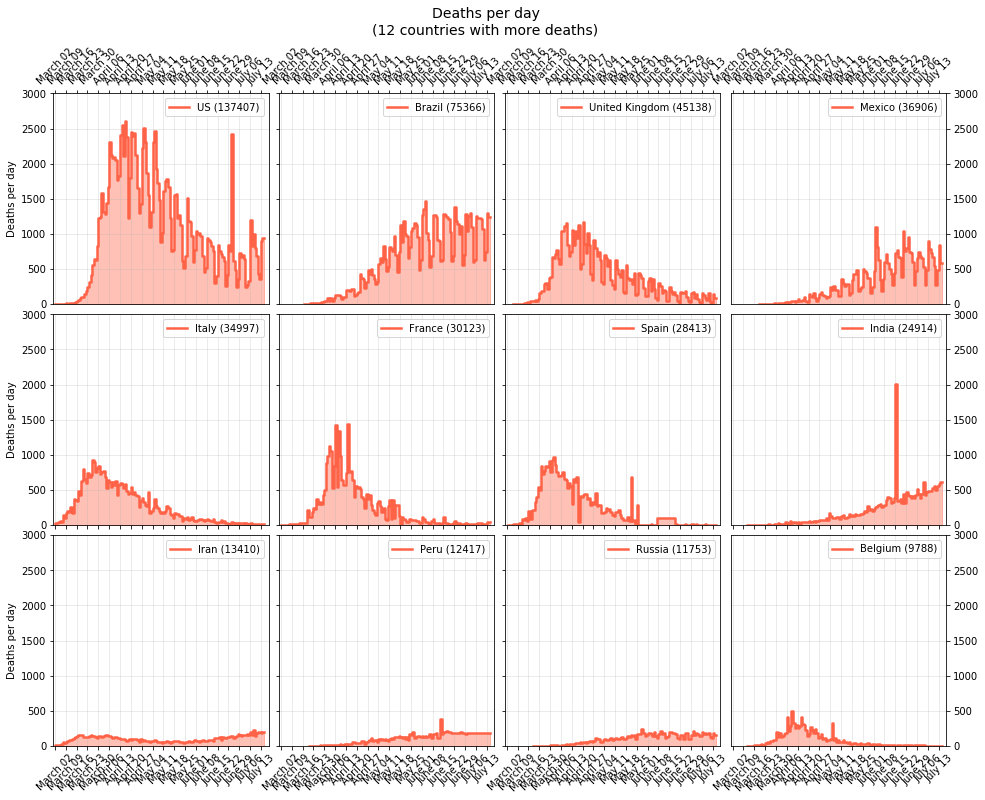

In [78]:
plot_country_deaths(data, death_lim=3000)

## World (except China)

#### Current today

#### 5 day prediction

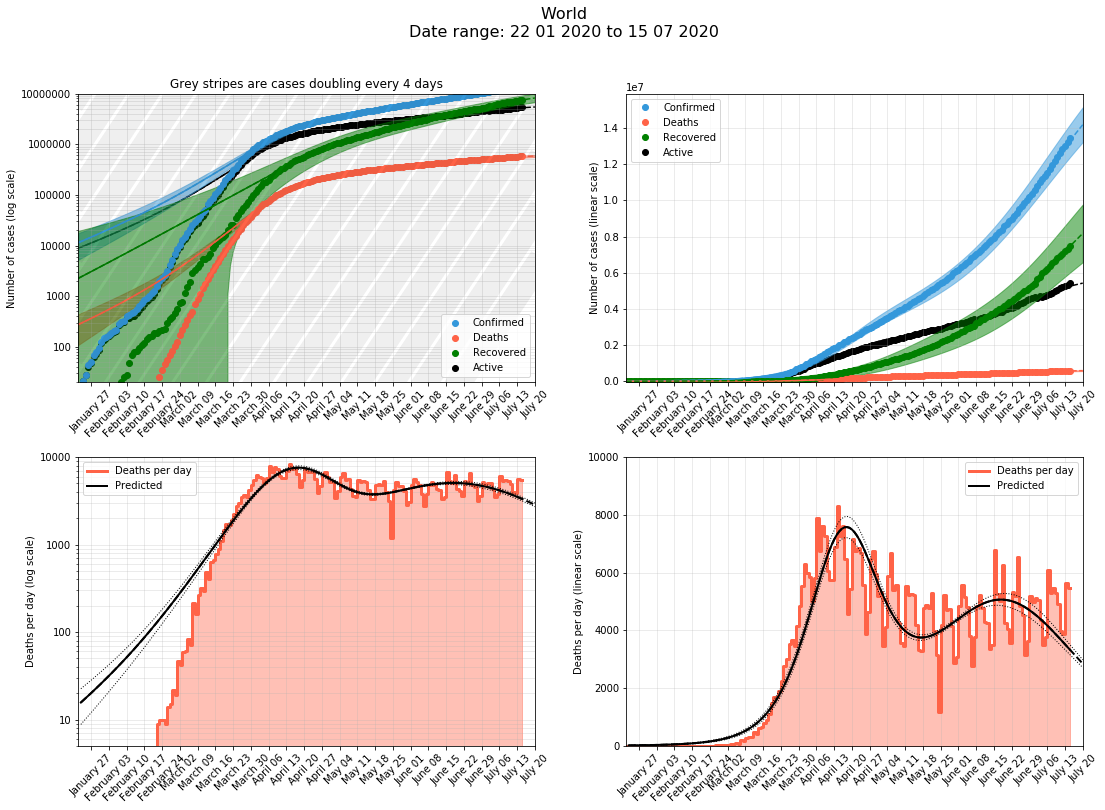

In [45]:
display(Markdown("## World (except China)"))
world_data = data[data['Country/Region']!='China']
all_countries = world_data.groupby(['DateTime']).sum().reset_index()
all_countries['Country/Region'] = 'World'
all_countries['Province/State'] = ''
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic, func_logistic2]}

p0 = {'Confirmed': {func_logistic2:[4e6, 0.8, 7.37532973e+05, 4e6, 0.6, 7.37532973e+05+20]},
      'Deaths':    {func_logistic2:[2e5, 0.9, 7.37532973e+05,1e5, 0.7, 7.37532973e+05+20]},
      'Recovered': {func_logistic2:[2e6, 0.9, 7.37532973e+05, 2e6, 0.6, 7.37532973e+05+20]}}

data_country, prediction = fit_data(all_countries, fits_todo=fits_todo1, p0=p0)
fig, ax = plot_country(data_country, prediction, ylim=10000000, death_lim=10000)
print_table(data_country, prediction, days=5)

## China

#### Current today

#### 5 day prediction

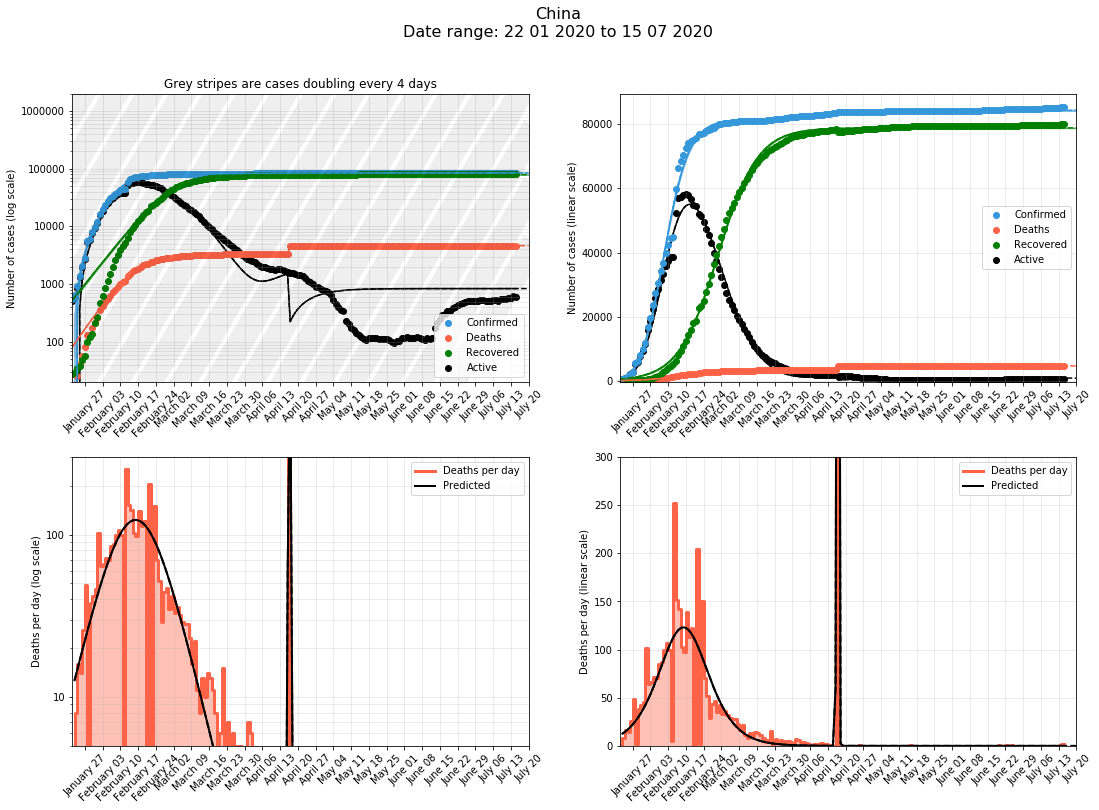

In [46]:
display(Markdown("## China"))
china_data = data[data['Country/Region']=='China']
china = china_data.groupby(['DateTime']).sum().reset_index()
china['Country/Region'] = 'China'
china['Province/State'] = ''
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic]}

data_country, prediction = fit_data(china, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction)
print_table(data_country, prediction, days=5)


In [47]:
display(Markdown("# Evolution of cases"))
display(Markdown("All plots have the same information. Left: log scale, right: linear scale. Top: number of confirmed cases, deaths, recovered cases and active cases. An exponential or logistic function is fitted to the data and plotted as a line, with the confidence interval covering uncertainties of the fitted parameters of 1-$\sigma$ . Bottom: deaths per day. Active cases is simply confirmed - (deaths + recovered). Also note that the number of confirmations is not homogeneous among countries because it depends on how many tests are done and to what part of the population. Bottom-right: is a zoom to show the correct scale for deaths. The straight line is a fit to a logistic growth when possible. If the fit does not converge (low number of points in early stages) a simple exponential is used. The dashed line is a prediction based on the fit. "))

#display(Markdown("# Europe"))

# Evolution of cases

All plots have the same information. Left: log scale, right: linear scale. Top: number of confirmed cases, deaths, recovered cases and active cases. An exponential or logistic function is fitted to the data and plotted as a line, with the confidence interval covering uncertainties of the fitted parameters of 1-$\sigma$ . Bottom: deaths per day. Active cases is simply confirmed - (deaths + recovered). Also note that the number of confirmations is not homogeneous among countries because it depends on how many tests are done and to what part of the population. Bottom-right: is a zoom to show the correct scale for deaths. The straight line is a fit to a logistic growth when possible. If the fit does not converge (low number of points in early stages) a simple exponential is used. The dashed line is a prediction based on the fit. 

## Spain

Spain is following Italy's behaviour and we should expect a smooth peak that lasts several days (more than the model predicts). That is because the peak should be sharp for a given population, but countries are the sum of several big cities with different peaks times. Therefore the peak is wider than predicted by the one-population curve fit. 

#### Current today

#### 5 day prediction

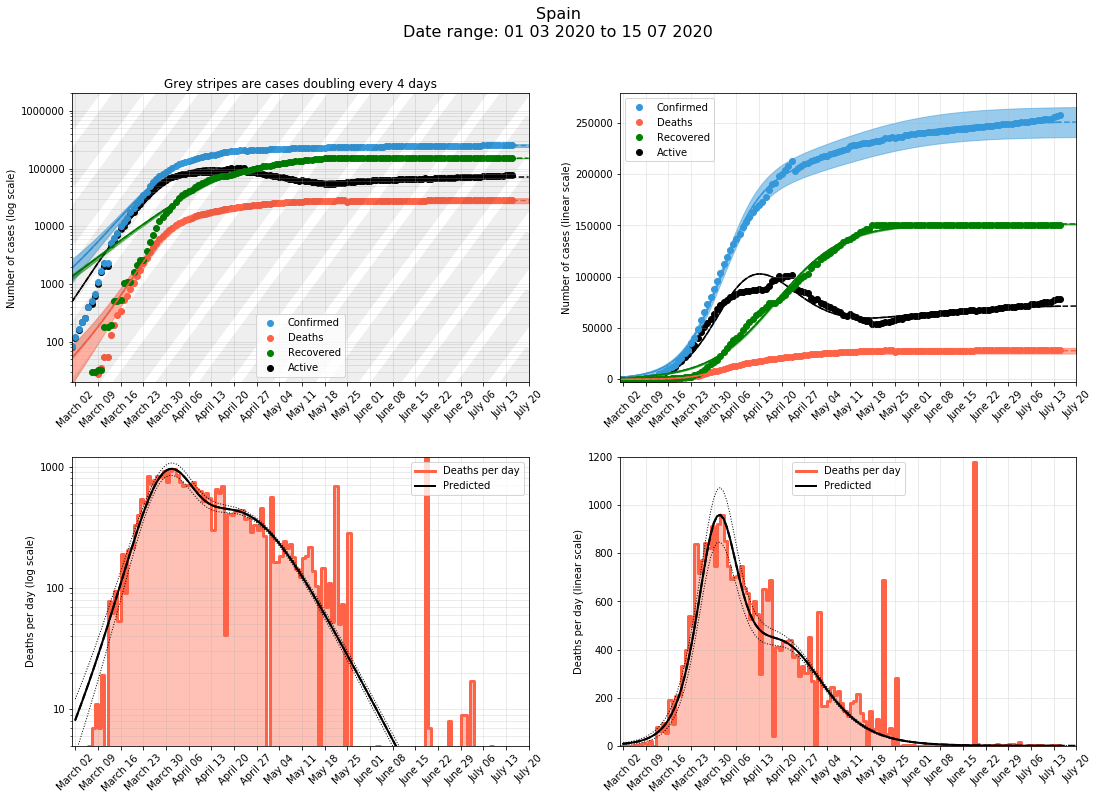

In [48]:
display(Markdown("## Spain"))
display(Markdown("Spain is following Italy's behaviour and we should expect a smooth peak that lasts several days (more than the model predicts). That is because the peak should be sharp for a given population, but countries are the sum of several big cities with different peaks times. Therefore the peak is wider than predicted by the one-population curve fit. "))
min_y1 = {'Confirmed': 2000, 'Deaths': 20, 'Recovered': 1000}
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic, func_logistic2]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.8, 'Recovered': 0.4}

p0 = {'Deaths': {func_logistic2:[1.40745658e+04, 2.37479155e-01, 7.37514682e+05, 1.36652510e+04, 1.20570604e-01, 7.37534960e+05]}}

spain = select_country(data, country='Spain', start_date='2020-03-01')
data_country, prediction = fit_data(spain, min_y = min_y1, fits_todo=fits_todo1, threshold=threshold1, p0=p0)
fig, ax = plot_country(data_country, prediction, death_lim=1200)

print_table(spain, prediction, days=5)

In [49]:
#plot_spain(spain, ccaa)

## Italy

#### Current today

#### 5 day prediction

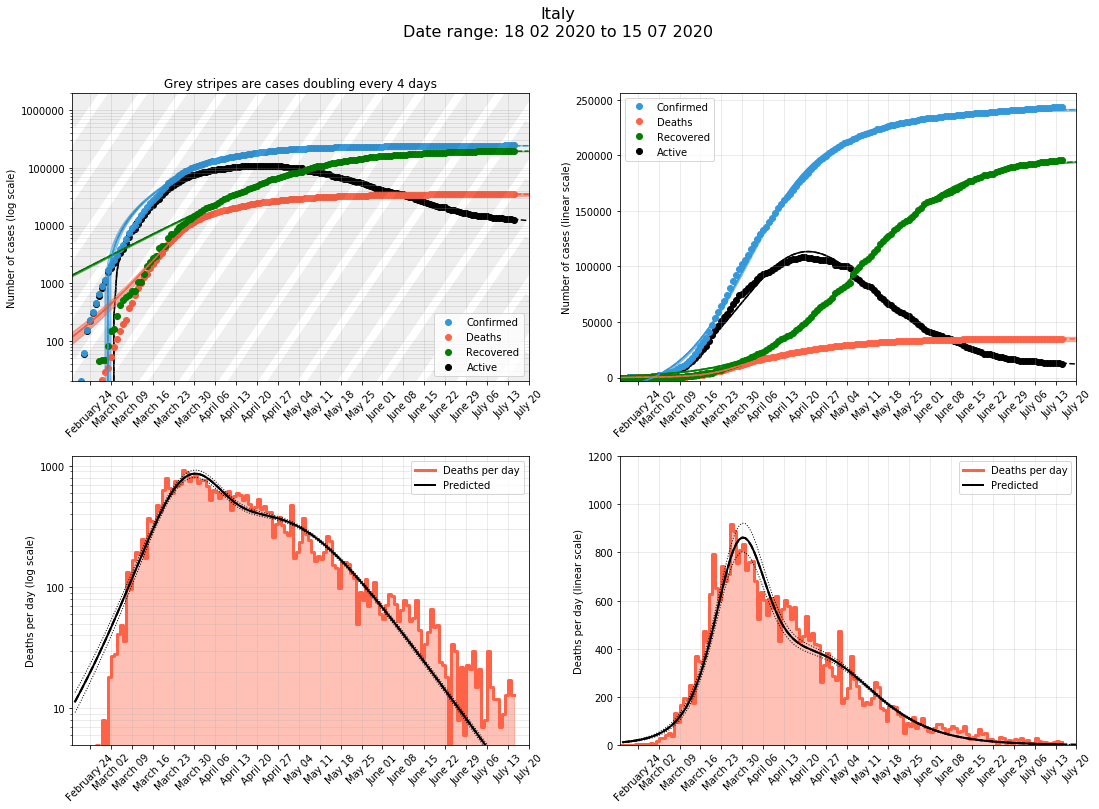

In [50]:
display(Markdown("## Italy"))
min_y1 = {'Confirmed': 10, 'Deaths': 10, 'Recovered': 10}
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_logistic2],
             'Recovered':  [func_exponential, func_logistic]}

threshold1 = {'Recovered': 0.3}
p0 = {'Deaths': {func_logistic2:[1.36426493e+04, 2.42352896e-01, 7.37514297e+05, 1.32125774e+04, 1.32390636e-01, 7.37533140e+05]}}

my_country = select_country(data, country='Italy', start_date='2020-02-18')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1, threshold=threshold1, p0=p0)
fig, ax = plot_country(data_country, prediction, death_lim=1200)
print_table(my_country, prediction, days=5)

## United Kingdom

#### Current today

#### 5 day prediction

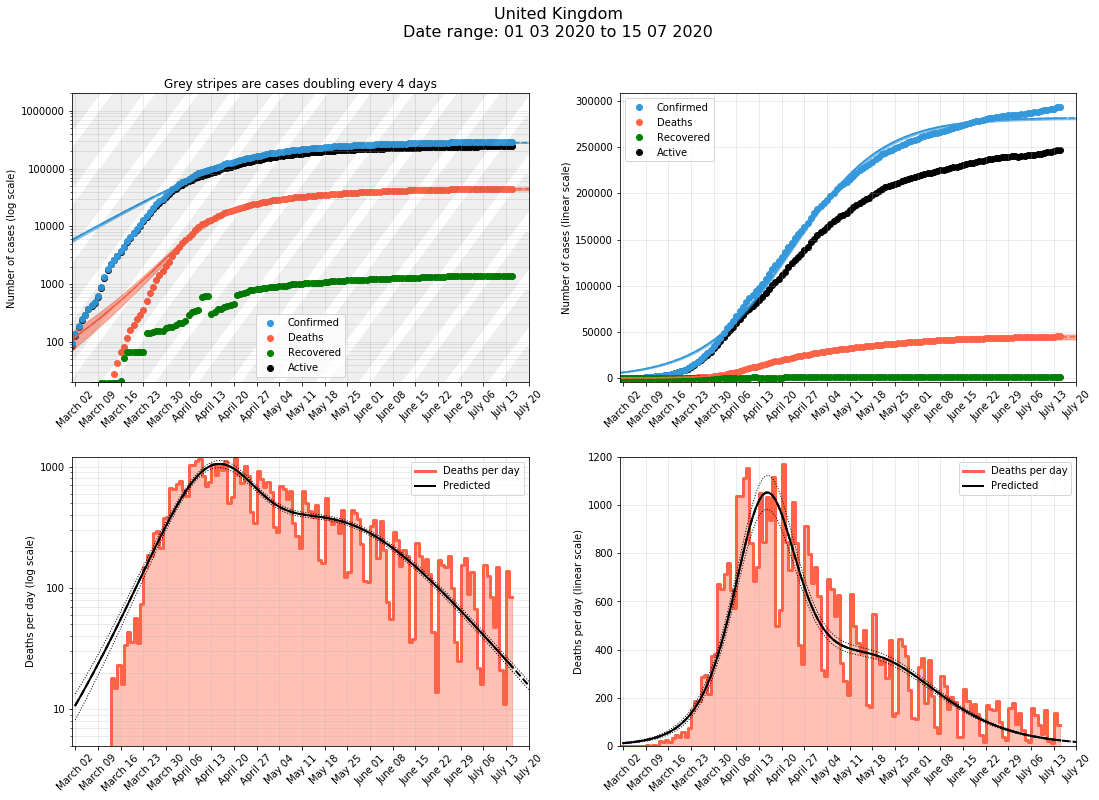

In [51]:
display(Markdown("## United Kingdom"))
min_y1 = {'Confirmed': 50, 'Deaths': 10, 'Recovered': 1}

fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic2],
             'Recovered':  [func_exponential]}

threshold1 = {'Recovered': 0.1}
p0 = {'Deaths': {func_logistic2:[1.36426493e+04, 2.42352896e-01, 7.37514297e+05, 1.32125774e+04, 1.32390636e-01, 7.37533140e+05]}}


my_country = select_country(data, country='United Kingdom',province='', start_date='2020-03-01')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1, p0=p0)
fig, ax = plot_country(data_country, prediction, death_lim=1200)
print_table(my_country, prediction, days=5)

## United States

#### Current today

#### 5 day prediction

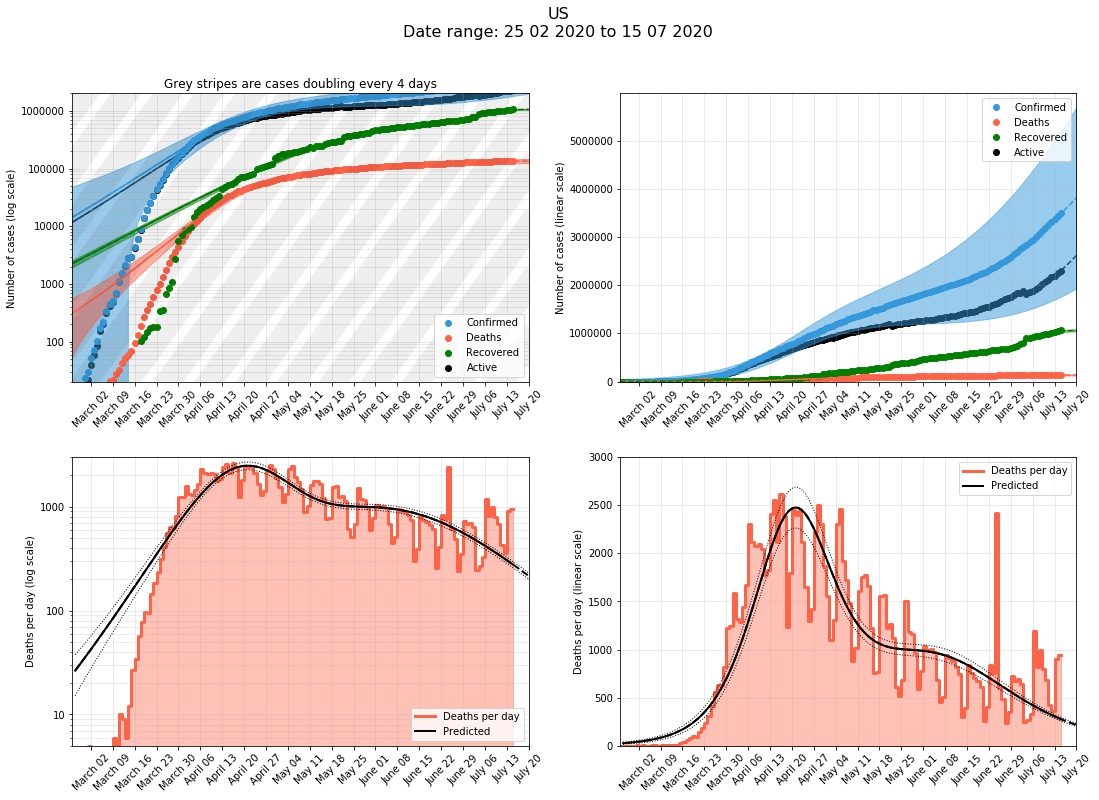

In [52]:
display(Markdown("## United States"))

#per_country = data.groupby(['DateTime','Country/Region']).sum().reset_index()
#usa = per_country[per_country['Country/Region']=='US']
#usa['Province/State'] = ''
min_y1 = {'Confirmed': 50, 'Deaths': 100, 'Recovered': 1000}
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic, func_logistic2]}

my_country = select_country(data, country='US', province='', start_date='2020-02-25')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction, death_lim=3000)
print_table(my_country, prediction, days=5)

## France

I think the huge increase of death numbers on April 3 is due to this: [France's Coronavirus Death Toll Jumps as Nursing Homes Included](https://www.usnews.com/news/world/articles/2020-04-02/frances-coronavirus-death-toll-jumps-to-nearly-5-400-as-nursing-homes-included). April 2, 2020

#### Current today

#### 5 day prediction

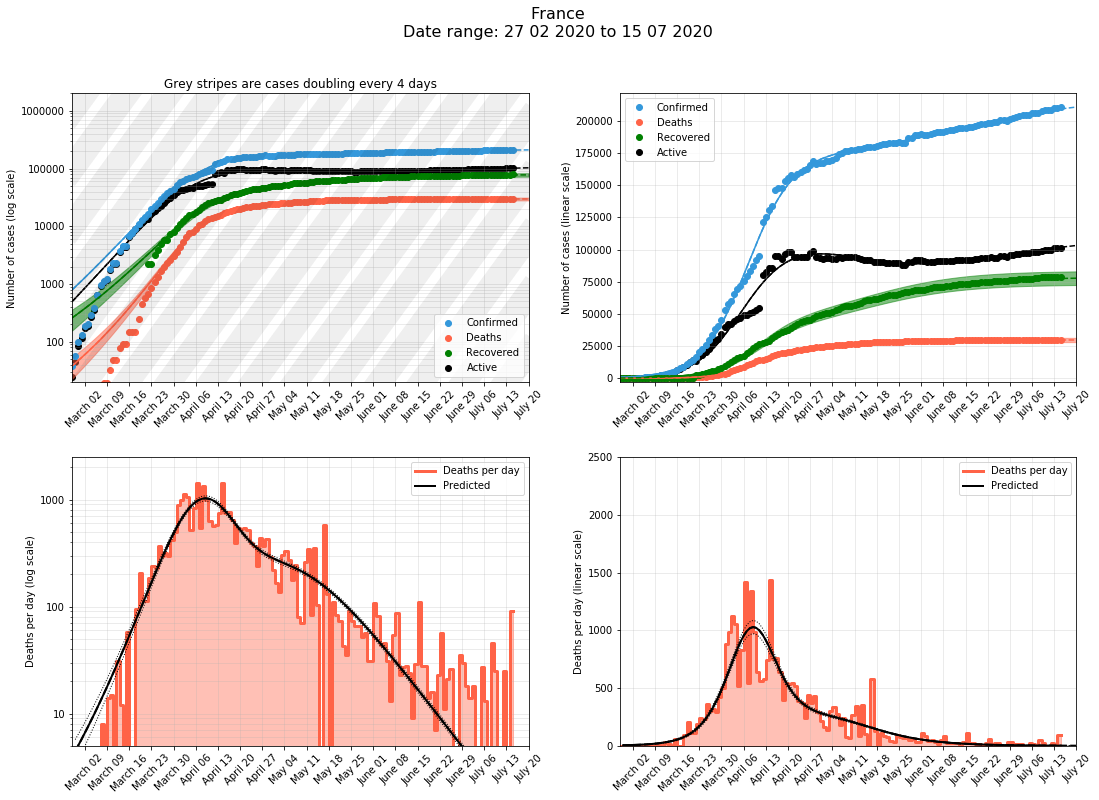

In [53]:
display(Markdown("## France"))
display(Markdown("I think the huge increase of death numbers on April 3 is due to this: [France's Coronavirus Death Toll Jumps as Nursing Homes Included](https://www.usnews.com/news/world/articles/2020-04-02/frances-coronavirus-death-toll-jumps-to-nearly-5-400-as-nursing-homes-included). April 2, 2020"))
min_y1 = {'Confirmed': 50, 'Deaths': 100, 'Recovered': 20}

fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic, func_logistic2]}

threshold1 = {'Confirmed': 0.3, 'Deaths': 0.5, 'Recovered': 0.3}
my_country = select_country(data, country='France',province='', start_date='2020-02-27')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction, death_lim=2500)
print_table(my_country, prediction, days=5)


In [54]:
death_lim2 = 200

## Germany

#### Current today

#### 5 day prediction

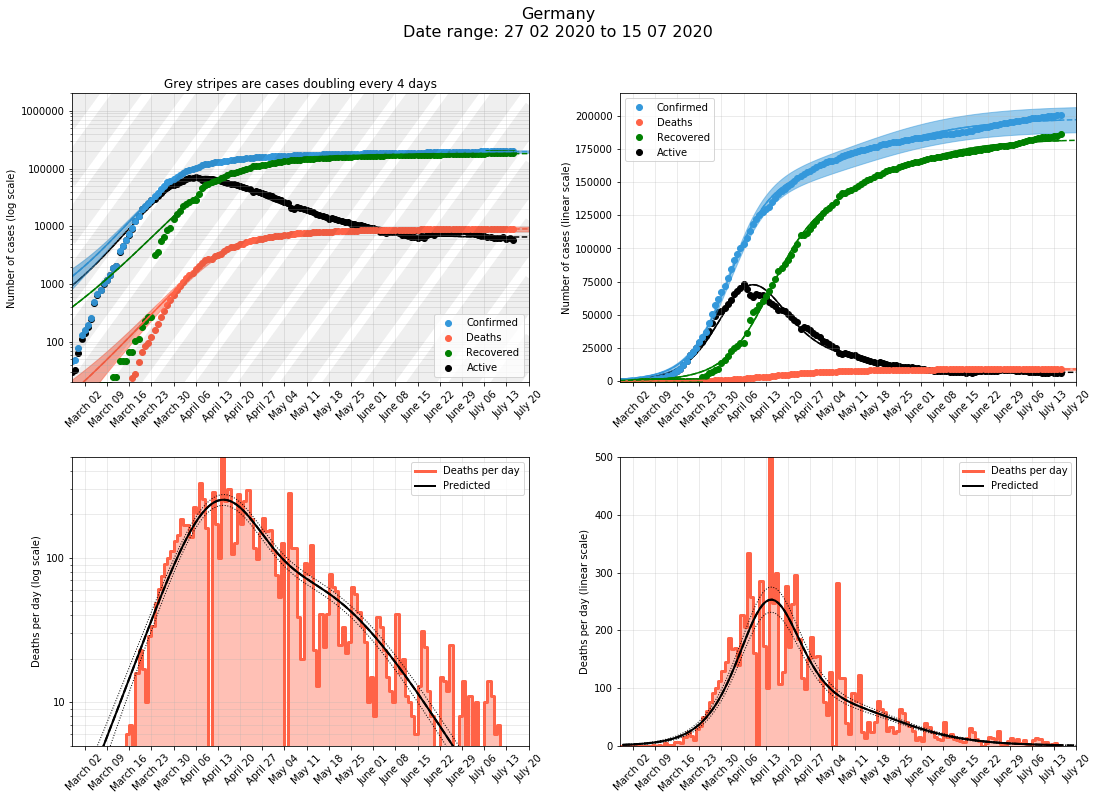

In [55]:
display(Markdown("## Germany"))
min_y1 = {'Confirmed': 50, 'Deaths': 100, 'Recovered': 0}

fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic, func_logistic2]}
threshold1 = {'Confirmed': 0.9, 'Deaths': 0.3, 'Recovered':0.2}

my_country = select_country(data, country='Germany',province='', start_date='2020-02-27')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction, death_lim=500)
print_table(my_country, prediction, days=5)

## Netherlands

#### Current today

#### 5 day prediction

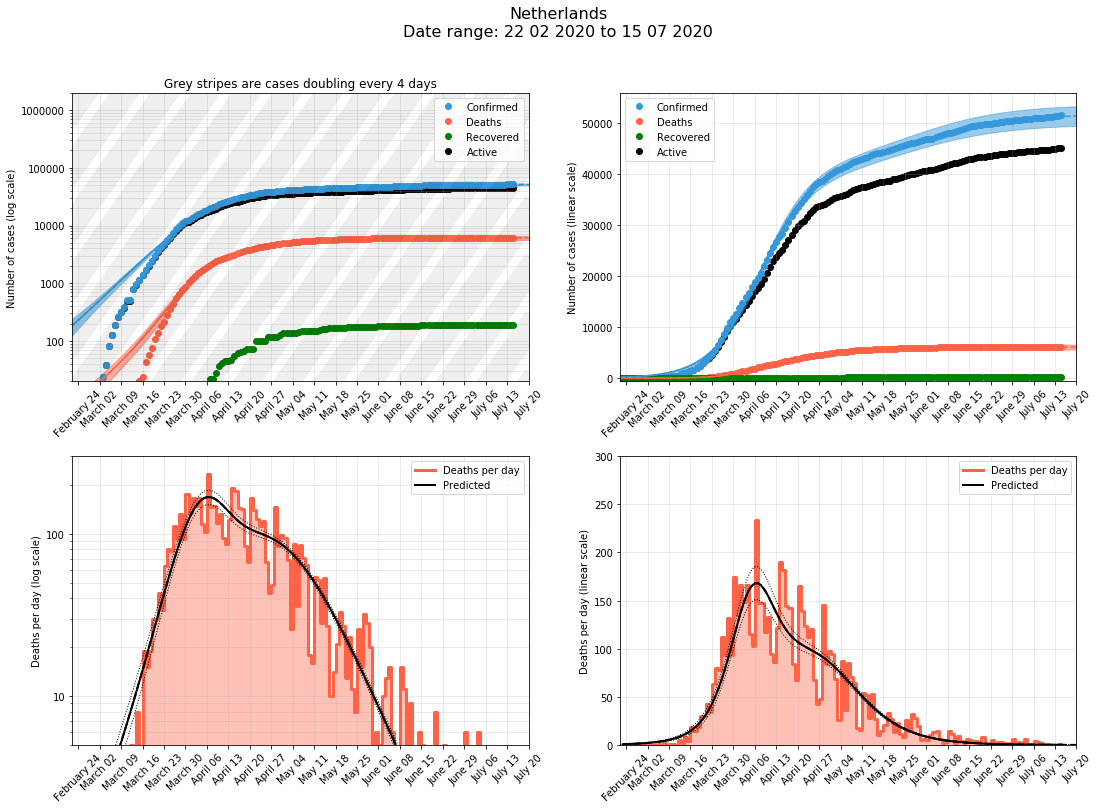

In [56]:
display(Markdown("## Netherlands"))
min_y1 = {'Confirmed': 10, 'Deaths': 4, 'Recovered': 0}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential]}

my_country = select_country(data, country='Netherlands',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction, death_lim=300)
print_table(my_country, prediction, days=5)


## Belgium

#### Current today

#### 5 day prediction

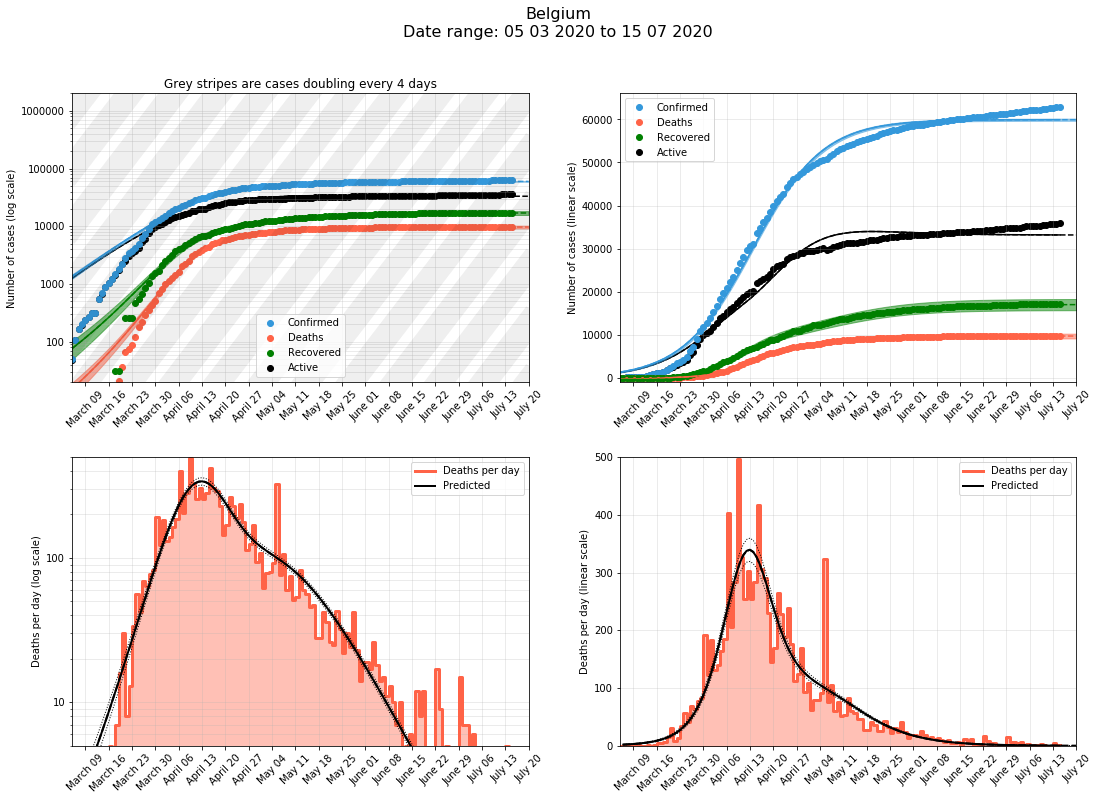

In [57]:
display(Markdown("## Belgium"))
min_y1 = {'Confirmed': 500, 'Deaths': 20, 'Recovered': 100}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic, func_logistic2]}

my_country = select_country(data, country='Belgium',province='', start_date='2020-03-05')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction, death_lim=500)
print_table(my_country, prediction, days=5)


## Sweden

#### Current today

#### 5 day prediction

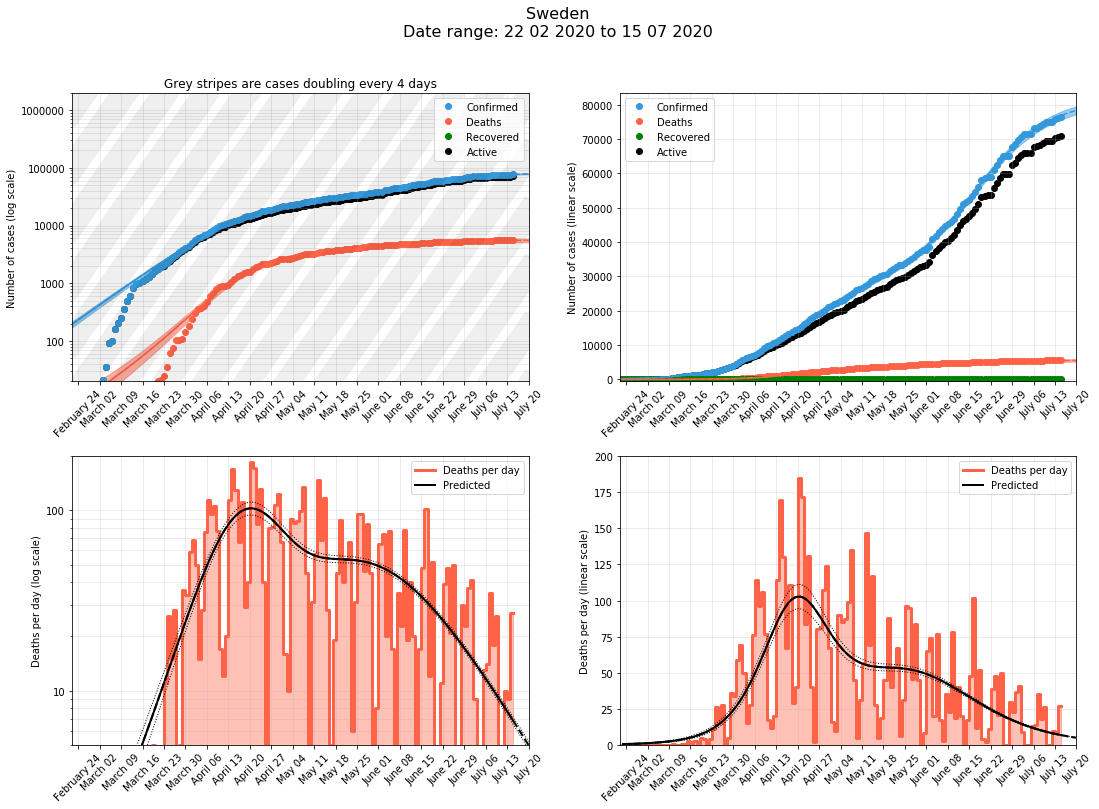

In [58]:
display(Markdown("## Sweden"))
min_y1 = {'Confirmed': 50, 'Deaths': 0, 'Recovered': 0}

fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic]}
threshold1 = {'Confirmed': 0.6, 'Deaths': 0.4, 'Recovered': 0.3}

my_country = select_country(data, country='Sweden',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1, threshold=threshold1)
fig, ax = plot_country(data_country, prediction, death_lim=death_lim2)
print_table(my_country, prediction, days=5)

## Poland

#### Current today

#### 5 day prediction

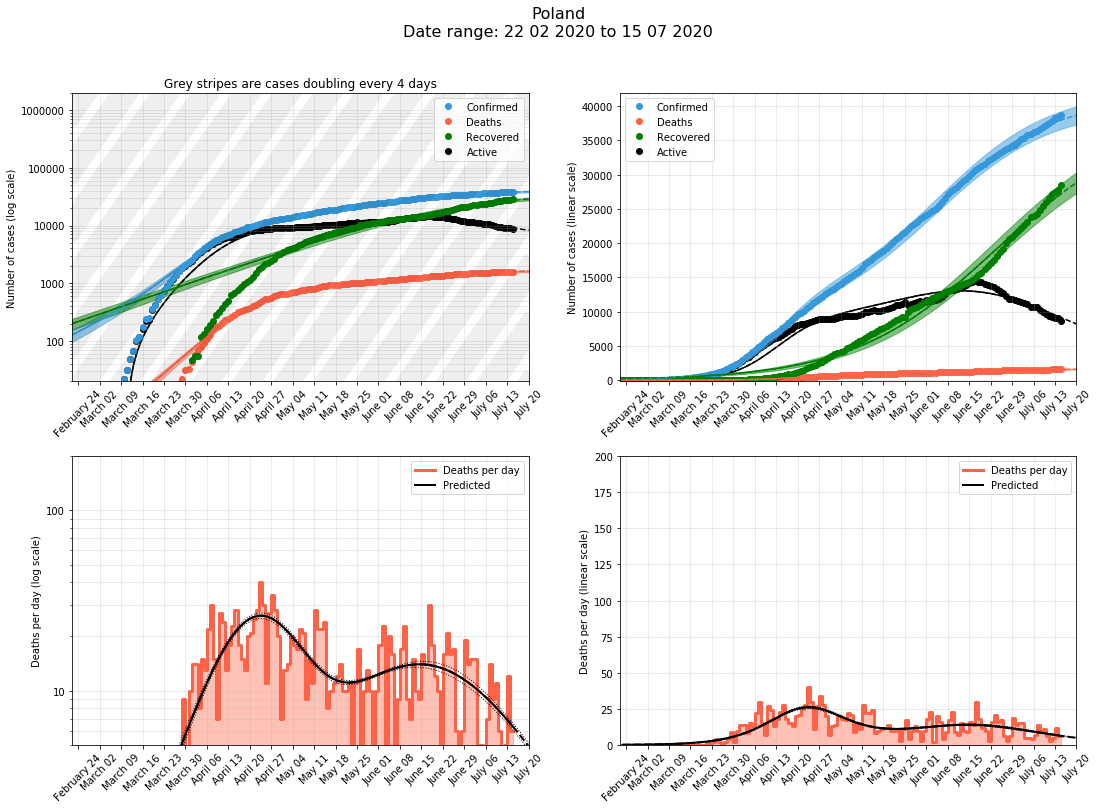

In [59]:
display(Markdown("## Poland"))
min_y1 = {'Confirmed': 10, 'Deaths': 50, 'Recovered': 100}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic]}

my_country = select_country(data, country='Poland',province='', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction, death_lim=death_lim2)
print_table(my_country, prediction, days=5)


## Switzerland

#### Current today

#### 5 day prediction

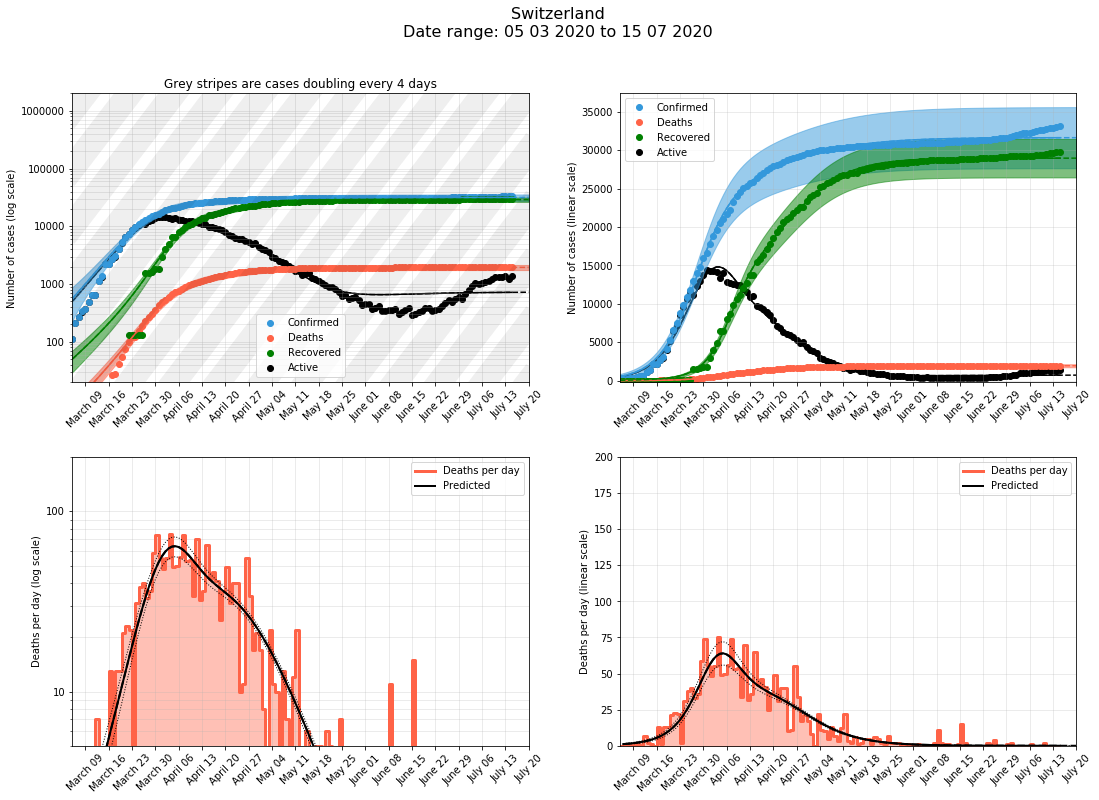

In [60]:
display(Markdown("## Switzerland"))
min_y1 = {'Confirmed': 10, 'Deaths': 10, 'Recovered': 10}
do_debug=False
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic, func_logistic2]}

my_country = select_country(data, country='Switzerland',province='', start_date='2020-03-05')
data_country, prediction = fit_data(my_country, min_y=min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction, death_lim=death_lim2)
print_table(my_country, prediction, days=5)


## Brazil

#### Current today

#### 5 day prediction

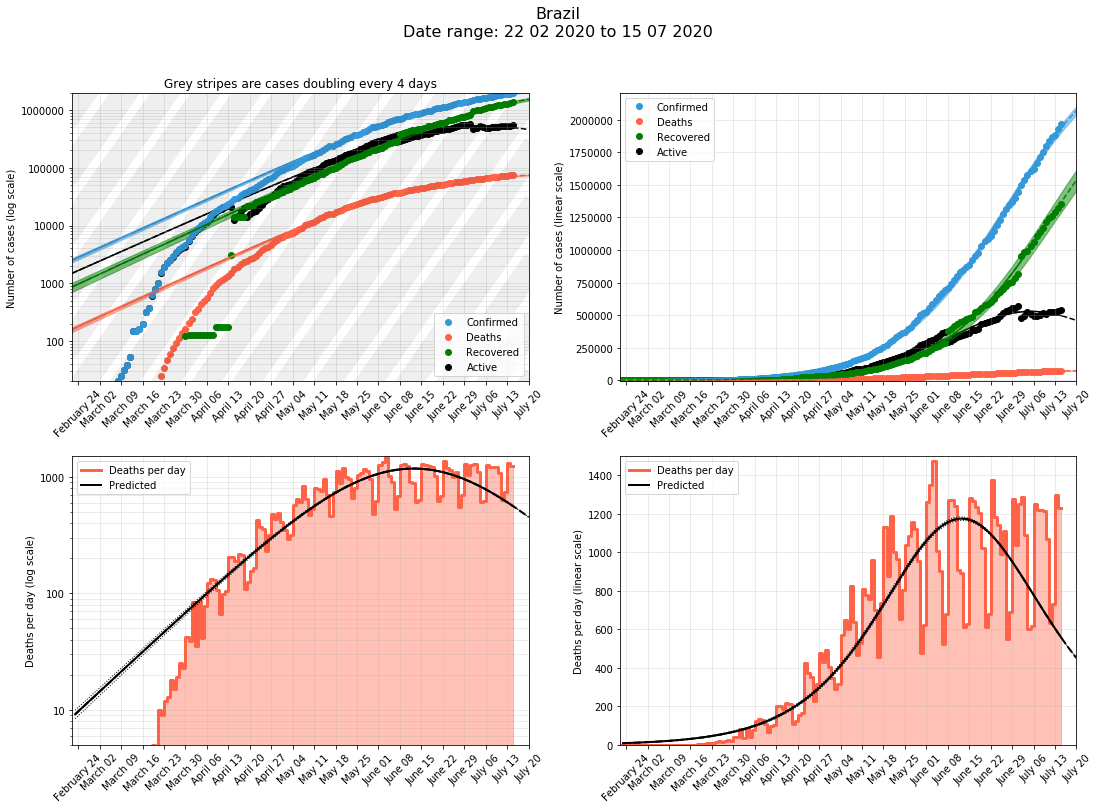

In [61]:
display(Markdown("## Brazil"))
min_y1 = {'Confirmed': 10000, 'Deaths': 100, 'Recovered': 1000}
fits_todo1 = {'Confirmed': [func_exponential, func_logistic],
             'Deaths':     [func_exponential, func_logistic],
             'Recovered':  [func_exponential, func_logistic]}

my_country = select_country(data, country='Brazil', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction, death_lim=1500)
print_table(my_country, prediction, days=5)

## Iran

#### Current today

#### 5 day prediction

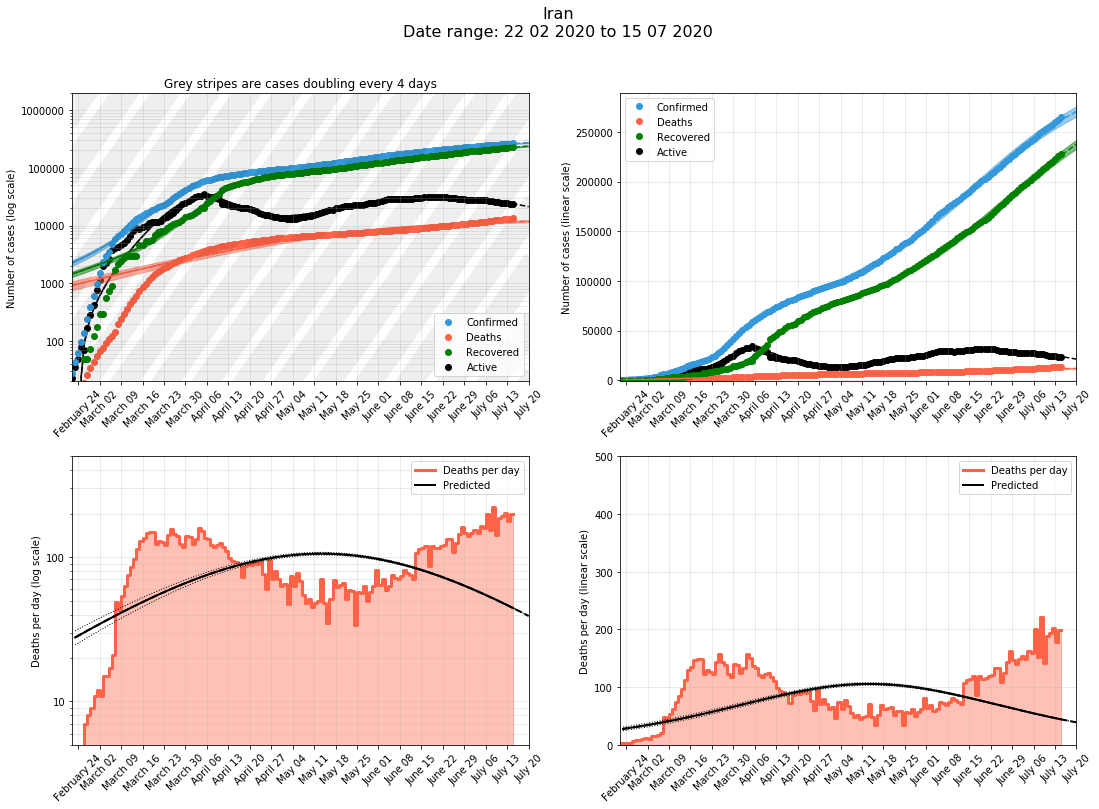

In [82]:
display(Markdown("## Iran"))
min_y1 = {'Confirmed': 10000, 'Deaths': 100, 'Recovered': 1000}
fits_todo1 = {'Confirmed': [func_exponential, func_logistic, func_logistic2],
             'Deaths':     [func_exponential, func_logistic, func_logistic2],
             'Recovered':  [func_exponential, func_logistic, func_logistic2]}

my_country = select_country(data, country='Iran', start_date='2020-02-22')
data_country, prediction = fit_data(my_country, min_y = min_y1, fits_todo=fits_todo1)
fig, ax = plot_country(data_country, prediction, death_lim=500)
print_table(my_country, prediction, days=5)

# Comparison of different countries

In [63]:
def compare_countries2(data, countries, lw1=2, name='comparison'):
    gridsize = (3, 2)
    fig = plt.figure(figsize=(16, 12))
    ax1 = plt.subplot2grid(gridsize, (0, 0))
    ax2 = plt.subplot2grid(gridsize, (1, 0))
    ax3 = plt.subplot2grid(gridsize, (2, 0))
    #ax4 = plt.subplot2grid(gridsize, (3, 0))
    ax1b = plt.subplot2grid(gridsize, (0, 1))
    ax2b = plt.subplot2grid(gridsize, (1, 1))
    ax3b = plt.subplot2grid(gridsize, (2, 1))
    #ax4b = plt.subplot2grid(gridsize, (3, 1))
    plt.subplots_adjust(hspace=0)

    for country in countries.keys():
        c = countries[country]
        my_country = select_country(data,
                                    country=c['country'],
                                    province=c.get('province', ''),
                                    start_date=c.get('start_date', '2020-02-15'),
                                    end_date=c.get('end_date', '2021-01-01'))
        data_country1, prediction1 = fit_data(my_country)

        symbol='x'
        l = ax1.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed'], symbol, label='')
        l = ax1.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax1.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Confirmed_pred'], '--', color=l[0].get_color(), label='')
        l = ax2.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths'], symbol, label='')
        l = ax2.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax2.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Deaths_pred'], '--', color=l[0].get_color(), label='')
        l = ax3.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered'], symbol, label='')
        l = ax3.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax3.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Recovered_pred'], '--', color=l[0].get_color(), label='')
        
        l = ax1b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed'], symbol, label='')
        l = ax1b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Confirmed_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax1b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Confirmed_pred'], '--', color=l[0].get_color(), label='')
        l = ax2b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths'], symbol, label='')
        l = ax2b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Deaths_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax2b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Deaths_pred'], '--', color=l[0].get_color(), label='')
        l = ax3b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered'], symbol, label='')
        l = ax3b.plot(data_country1['DateTime']+datetime.timedelta(days=c['delay']), data_country1['Recovered_fit'], '-', color=l[0].get_color(), lw=lw1, label=f'{country} ({c["delay"]}d)')
        l = ax3b.plot(prediction1['DateTime']  +datetime.timedelta(days=c['delay']), prediction1['Recovered_pred'], '--', color=l[0].get_color(), label='')
       
        
    #ax3.set_ylim(0, np.max(data_country['Deaths'])*1.5)
    #ax2.set_ylim(0,1e5)
    #ax1.set_ylim(0.5,1e5)

    ax1.set_ylabel('Confirmed')
    ax2.set_ylabel('Deaths')
    ax3.set_ylabel('Recovered')
    
    for ax in [ax1,ax2,ax1b,ax2b]:
        ax.xaxis.set_ticklabels([])
    ax3.xaxis.set_tick_params(rotation=45)
    ax3b.xaxis.set_tick_params(rotation=45)
    ax1.set_title('Log scale')
    ax1b.set_title('Linear scale')
    #fig.suptitle(f'{country} {province}\nDate range: {start_date} to {end_date}', fontsize=16)

    for ax in [ax1,ax2,ax3]:
        ax.set_yscale('log')
    
    for ax in [ax1,ax2,ax3,ax1b,ax2b,ax3b]:
        ax.set_ylim(0.5,)
        ax.legend()
        
    fig.savefig(f'./plots/{name}.png', bbox_inches='tight', dpi=100)
        

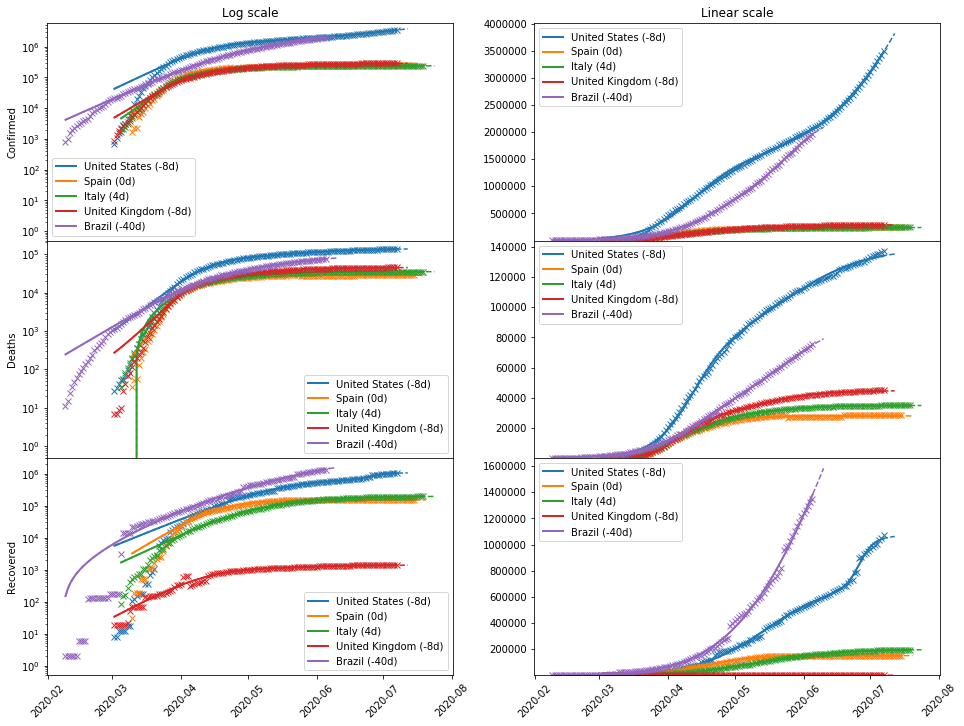

In [64]:
countries = {
    #'France': {'country': 'France', 'province': '', 'start_date':'2020-03-10', 'end_date':'2021-01-01', 'delay': -10},
    'United States': {'country': 'US', 'province': '', 'start_date':'2020-03-10', 'end_date':'2021-01-01', 'delay': -8},
    'Spain': {'country': 'Spain', 'start_date':'2020-03-10', 'end_date':'2021-01-01', 'delay': 0},
    'Italy': {'country': 'Italy', 'start_date':'2020-03-01', 'end_date':'2021-01-01', 'delay': 4},
    #'Germany': {'country': 'Germany', 'start_date':'2020-02-15', 'end_date':'2021-01-01', 'delay': 5},
    'United Kingdom': {'country': 'United Kingdom', 'start_date':'2020-03-10', 'end_date':'2021-01-01', 'delay': -8},
    'Brazil': {'country': 'Brazil', 'start_date':'2020-03-20', 'end_date':'2021-01-01', 'delay': -40},

}
compare_countries2(data, countries, name='comparison1')

In [65]:
### Early onset: China regions
#
#Most of the regions have almost completed the cycle and active cases are disappearing. Note that China Hubei (the original area) has a large number of confirmed cases (70000), but the other regions have very low number of cases, with number around 1200-500 or even less.

In [66]:
#idx = data.groupby(['Country/Region'])[['Confirmed','Deaths']].sum().sort_values(by='Deaths')[::-1][0:10].index
#for i in idx:
#    country = i
#    if country == 'China':
#        data_country, prediction, fig, ax = process_country(data, country=country, province='')

## Other countries

South Korea has a remarkable recovery rate, with many cases and a reduced number of deaths. Japan growth is moderate, much smaller than in European countries. Iran is showing hints of flattening, although it is curious that the number of recoveries has significantly slowed down while the number of deaths still follow a very exponential trend.


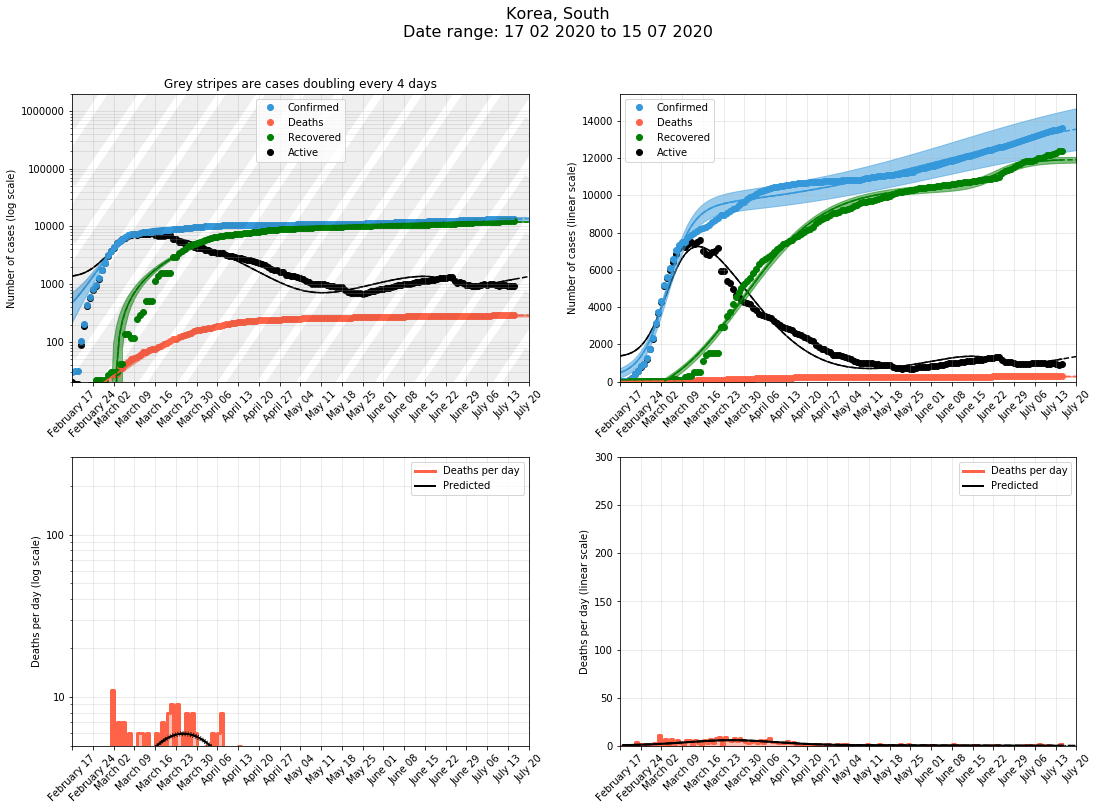

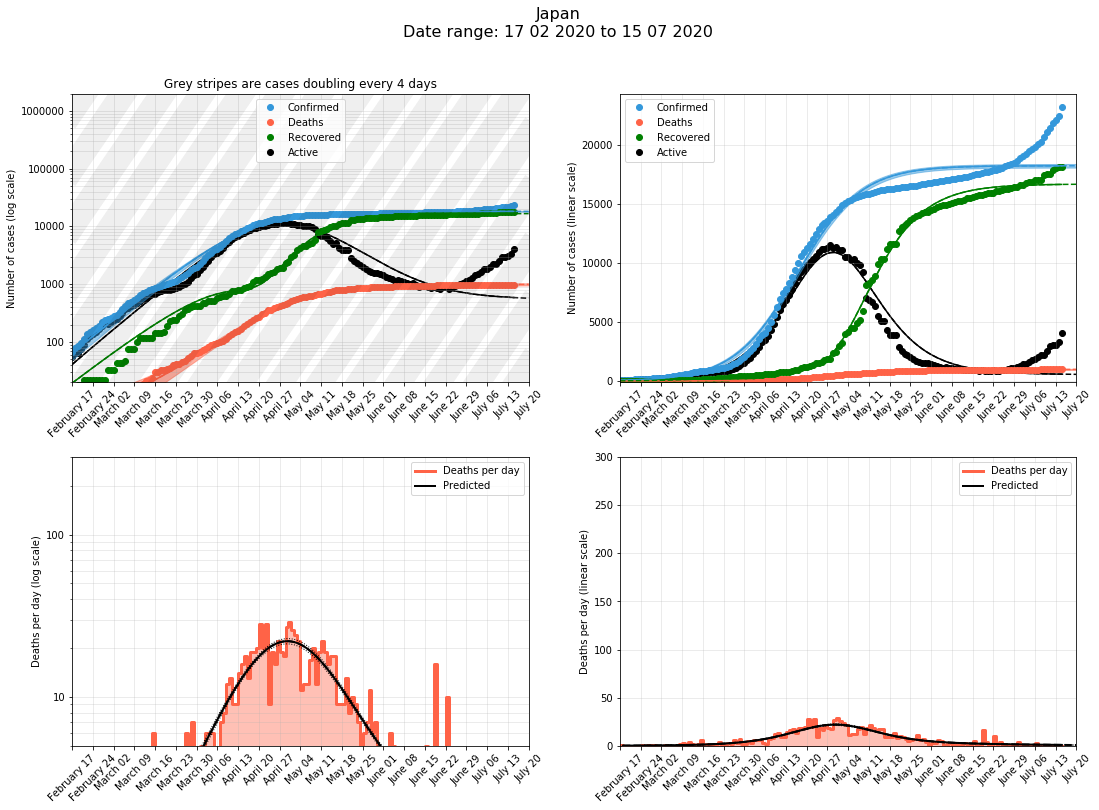

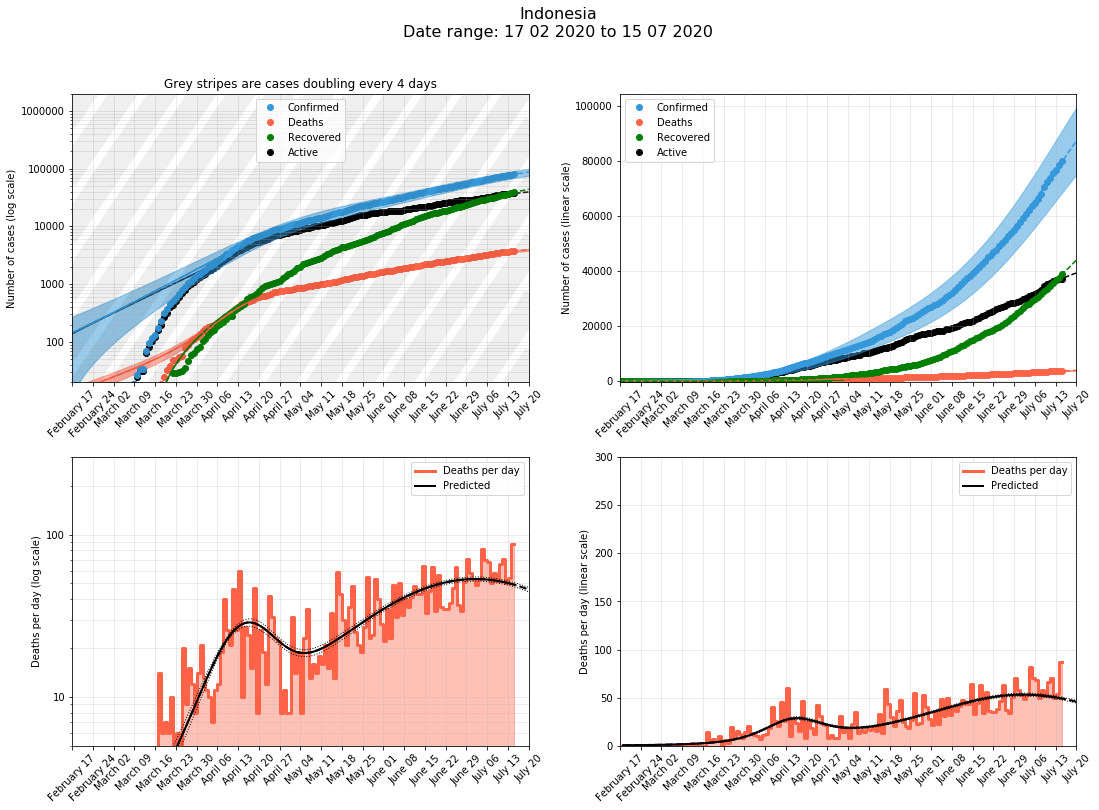

In [67]:
europe_list = [
    ['Korea, South', ''],
    ['Japan', ''],
    ['Indonesia', '']
]
for country, province in europe_list:
    data_country, prediction, fig, ax = process_country(data, country=country,  start_date='2020-02-17')